# Class 2: Network Sparsification & Link Prediction

Goal of today's class:
1. Introduce network reduction/filtering/thresholding
2. Introduce biases emerging in thresholding
3. Introduce weighted disparity filter
- BREAK
4. Define canonical link prediction tasks
5. Introduce basic measures for link prediction
6. Discuss techniques for evaluating link prediction algorithms

*Content Acknowledgements: Parts of this lesson draw from material by Matteo Chinazzi and Qian Zhang. Much of it is adapted from the 2024 final projects of [Daniel González Quezada](https://github.com/danielugq) and [Yixuan Liu](https://github.com/liu-yi-xuan), PhD students in Network Science at Northeastern University!*
__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_02/ folder.
________

In [77]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## How today fits together

Today’s class is a deliberately “combo” session: **network sparsification** followed by **link prediction**. The connective tissue is that both topics are, in practice, about *edge selection*.

In the first half, we start from a graph that is too dense (or too noisy) for the task at hand and ask how to construct a smaller edge set that still preserves the structures we care about. In this notebook, that includes both blunt tools (like global thresholding) and more statistically motivated backbones for weighted networks (like the disparity filter and marginal-likelihood ideas). A recurring theme will be that sparsification is never neutral: simple rules like thresholding can systematically reshape degree distributions, connectivity, and who remains “visible” in the network.

In the second half, we flip the perspective and treat the observed graph as incomplete. Link prediction asks which *absent* edges are most plausible given the structure we already see, and it forces us to be explicit about evaluation: how we hide edges, how we generate negative examples, and what metrics mean in a heavily imbalanced setting.


Even though one half removes edges and the other adds them, both rely on the same underlying idea: network structure contains signals that can be used to rank edge candidates, whether those candidates are present edges competing to be retained or missing edges competing to be added.
_________

### Before we get there!
1. Github: https://github.com/network-science-data-and-models/cnet5052_sp26
2. Project proposals, mini presentations next week
3. Problem set (Assignment 1 is long and relatively difficult)
4. Office hours
5. Other administrative questions?

_____
## Part 1: Sparsification

Real networks are often big, dense, noisy, and full of redundant connections. Airline networks, coauthorship graphs, correlation networks, and bipartite projections all generate graphs where a huge fraction of node pairs are linked by something. If we try to visualize or analyze these networks directly, we quickly run into both conceptual and computational limits: the hairball plots are unreadable, and algorithms that scale with $|E|$ or worse (all-pairs shortest paths, betweenness, some community detection methods, large-scale simulations) become expensive.

In this chapter we study **network sparsification**: the problem of replacing a given graph by a much sparser graph on the same set of nodes that still *behaves like* the original for certain tasks. The sparsified graph should be small enough to work with comfortably, but still preserve the structures or statistics we care about: shortest paths, centralities, communities, flows, diffusion processes, and so on.

Intuitively, sparsification is about extracting a **backbone** or **skeleton** of a network: a reduced set of edges that carries most of the structural signal and discards as much redundancy and noise as possible.

In [78]:
G = nx.karate_club_graph()
nodes = list(G.nodes())
G_edges = list(G.edges())
pos = nx.spring_layout(G)

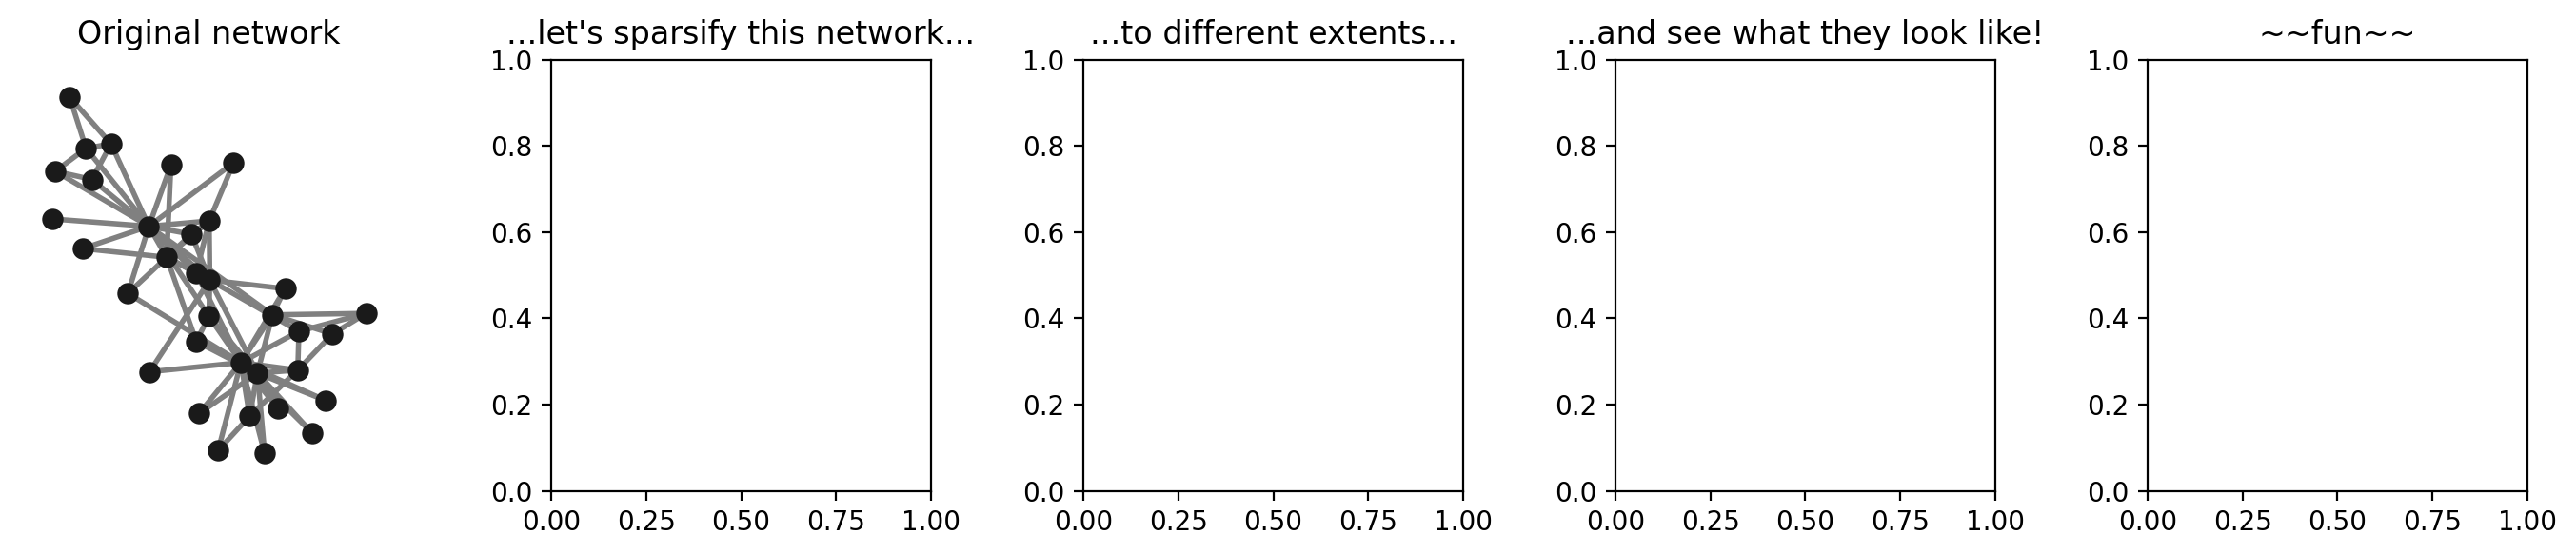

In [80]:
fig, ax = plt.subplots(1,5,figsize=(17,3),dpi=200)
plt.subplots_adjust(wspace=0.4)

nx.draw(G, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[0])
ax[0].set_title('Original network')

ax[1].set_title("...let's sparsify this network...")
ax[2].set_title("...to different extents...")
ax[3].set_title("...and see what they look like!")
ax[4].set_title('~~fun~~')


plt.show()

...is sparsification as easy as just... removing edges?

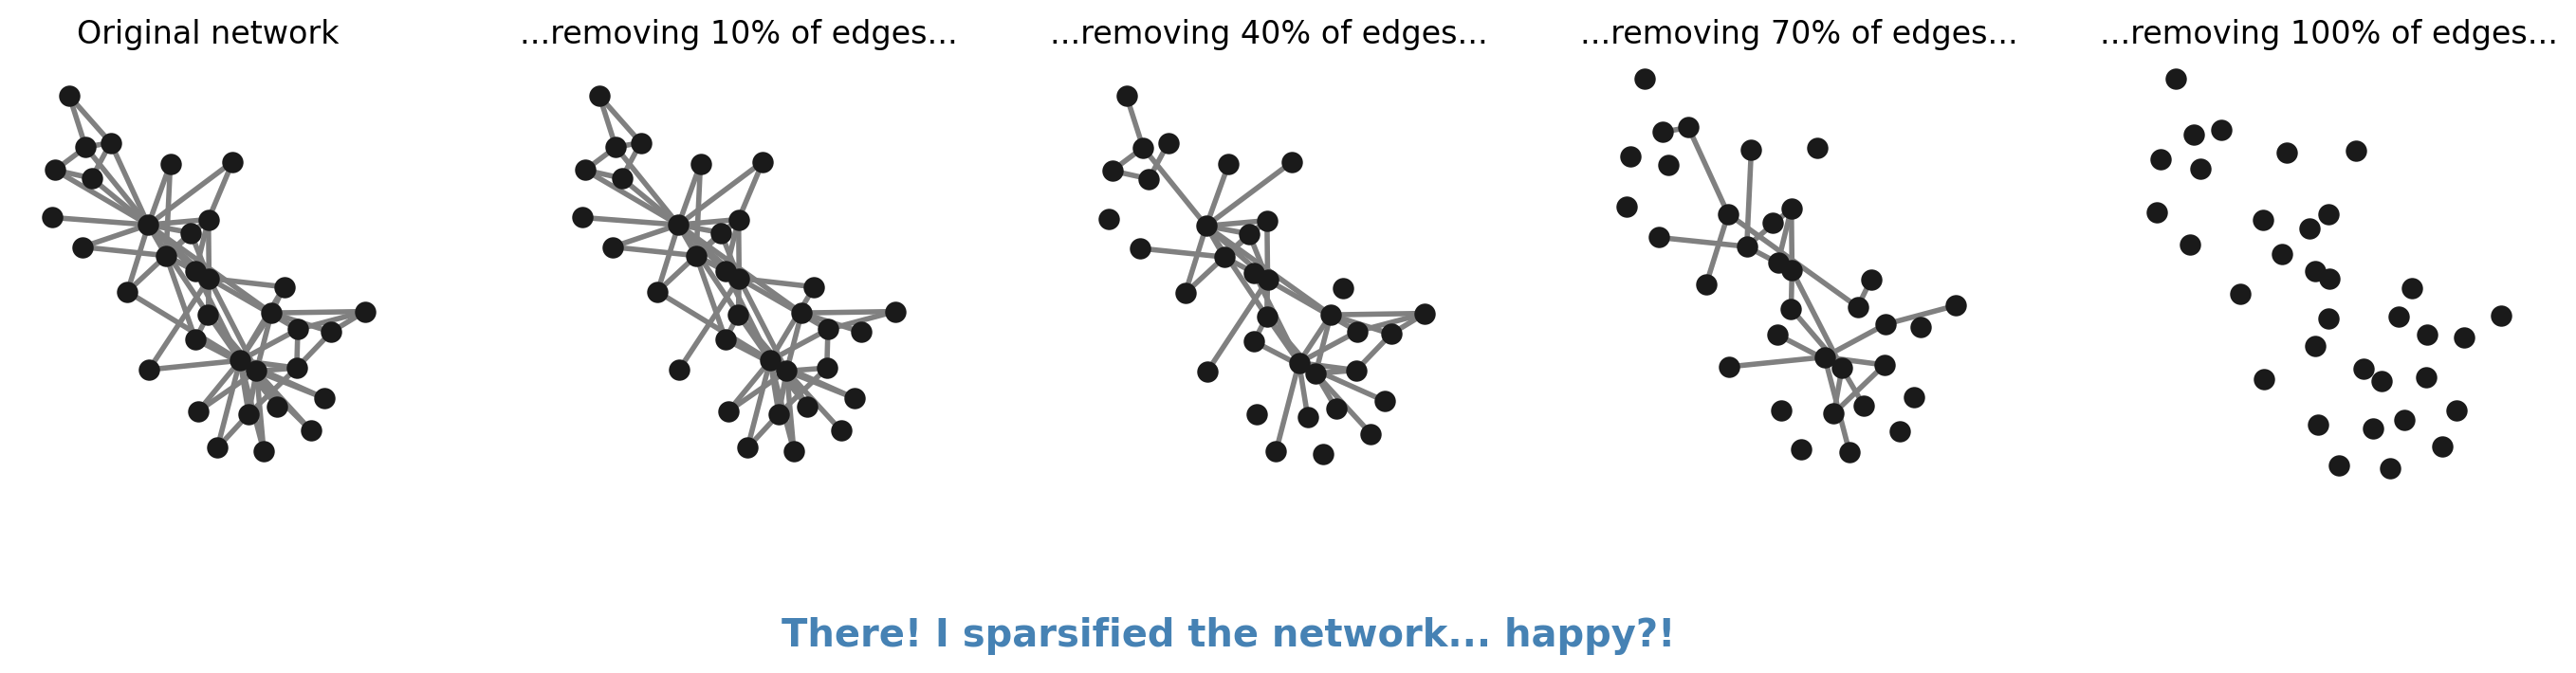

In [81]:
fig, ax = plt.subplots(1,5,figsize=(17,3),dpi=200)
plt.subplots_adjust(wspace=0.4)

nx.draw(G, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[0])
ax[0].set_title('Original network')


# remove 10% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.9*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[1])
ax[1].set_title('...removing 10% of edges...')

# remove 40% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.6*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[2])
ax[2].set_title('...removing 40% of edges...')

# remove 70% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.3*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[3])
ax[3].set_title('...removing 70% of edges...')


# remove 100% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.0*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[4])
ax[4].set_title('...removing 100% of edges...')


plt.suptitle('There! I sparsified the network... happy?!', color='steelblue', fontsize='x-large', y=-0.1, fontweight='bold')

plt.show()

### Sparsification, sampling, and filtering

It is useful to distinguish sparsification from a few closely related ideas that appear in other parts of the course.

**Sampling** asks how to select a subset of nodes or edges when we cannot or do not want to observe the full graph. The sampled graph is mainly a tool for *estimating* properties of an underlying, unobserved network.

**Filtering and thresholding** start from a weighted graph and ask which edges are statistically meaningful. Methods like disparity filters or likelihood-based backbones treat weights as noisy measurements, compare them to a null model, and keep only edges whose weights are unexpectedly large. The goal is to identify significant ties, not necessarily to approximate every structural aspect of the original network.

**Sparsification** assumes we already have the full graph and want to construct a smaller graph on the same nodes that approximates the original. Here we are not trying to estimate an unknown network; instead, we are constructing a surrogate graph that is cheaper to store, visualize, and analyze, while still supporting similar results for specific downstream tasks.

A convenient way to think about sparsification is as a two-step "score + filter" procedure:

1. Assign each edge $e \in E$ an importance score $s(e)$ based on some structural criterion (degree of its endpoints, neighborhood overlap, effective resistance, etc.).
2. Select a reduced edge set $E' \subset E$ using a global or local rule (for example, keep the top $q$ fraction of edges overall, or keep only the top $k$ edges incident to each node).


Most practical sparsification methods can be understood as choices of scoring function and filtering rule.

______
### What does it mean to *approximate* a graph?

A sparsifier of a graph $G = (V,E)$ is another graph $H = (V,E')$ on the same node set (usually) $|V(H)| = |V(G)|$ and a much smaller edge set $|E'| \ll |E|$ that approximates $G$ with respect to some property of interest. Different choices of property lead to different notions of sparsification. In principle, it is possible to compress a dense graph down to $O(n \log n)$ edges while still preserving strong global properties. In practice, however, such algorithms can be too heavy for everyday data analysis, and the property we care most about is usually much more specific than "all cuts" or "all quadratic forms". This motivates simpler, task-driven sparsifiers that are easier to implement and reason about.

In [99]:
edges = pd.read_csv('data/openflights_USairport_2010.txt', sep=' ', header=None,
                    names=['source','target','weight'])
nodes = pd.read_csv('data/openflights_airports.txt', sep=' ')


w_edge_dict = dict(zip(list(zip(edges['source'],
                                edges['target'])),
                       edges['weight']))

In [100]:
G = nx.Graph()
G.add_nodes_from(nodes['Airport ID'].values)
G.add_edges_from([(int(i),int(j),{'weight':k})
                  for i,j,k in list(edges.values)])

Gx = nx.subgraph(G, max(nx.connected_components(G), key=len))

In [101]:
N = G.number_of_nodes()
M = G.number_of_edges()
print("Number of Airports:", N)
print("Number of Connections:", M)

Number of Airports: 6675
Number of Connections: 17215


In [102]:
pos = dict(zip(nodes['Airport ID'].values,
               list(zip(nodes['Longitude'],nodes['Latitude']))))

In [103]:
for x in [i for i in G.nodes() if i not in pos.keys()]:
    try:
        pos[x] = pos[x+1]
    except:
        pos[x] = pos[x-1]

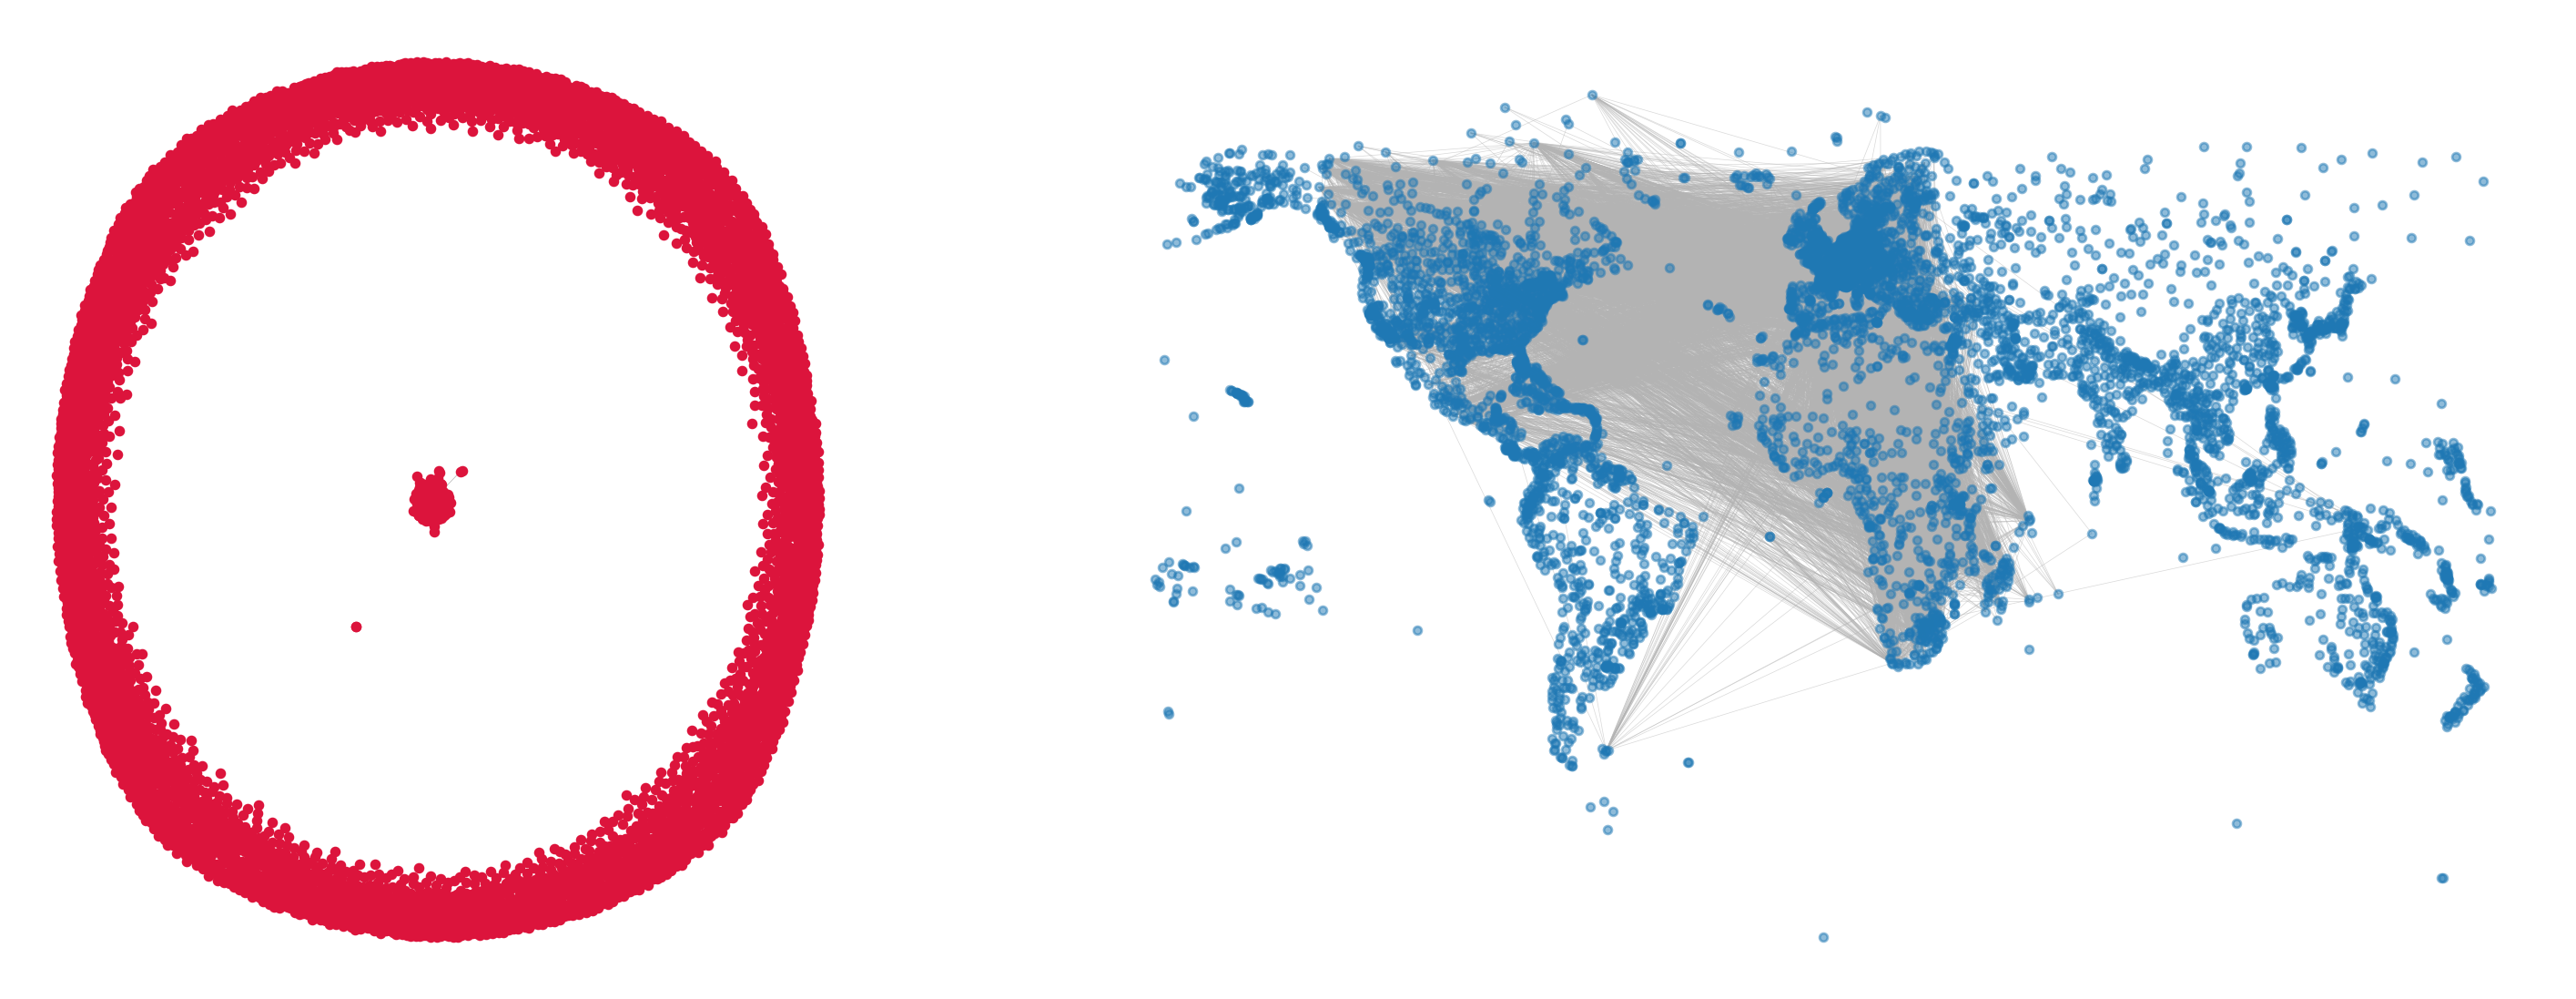

In [104]:
fig, ax = plt.subplots(1,2,figsize=(18,7),
                       gridspec_kw={'width_ratios':[2,3.5]},
                       dpi=200)

nx.draw(G, node_size=10, edge_color='.7', width=0.25, ax=ax[0], node_color='crimson')


nx.draw(G, pos={i:pos[i] for i in G.nodes()}, node_size=10,
        edge_color='.7', width=0.25, ax=ax[1], alpha=0.5)


plt.show()

In [105]:
def get_binning(data, num_bins=40, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
#     if len(values) != len(data):
#         print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

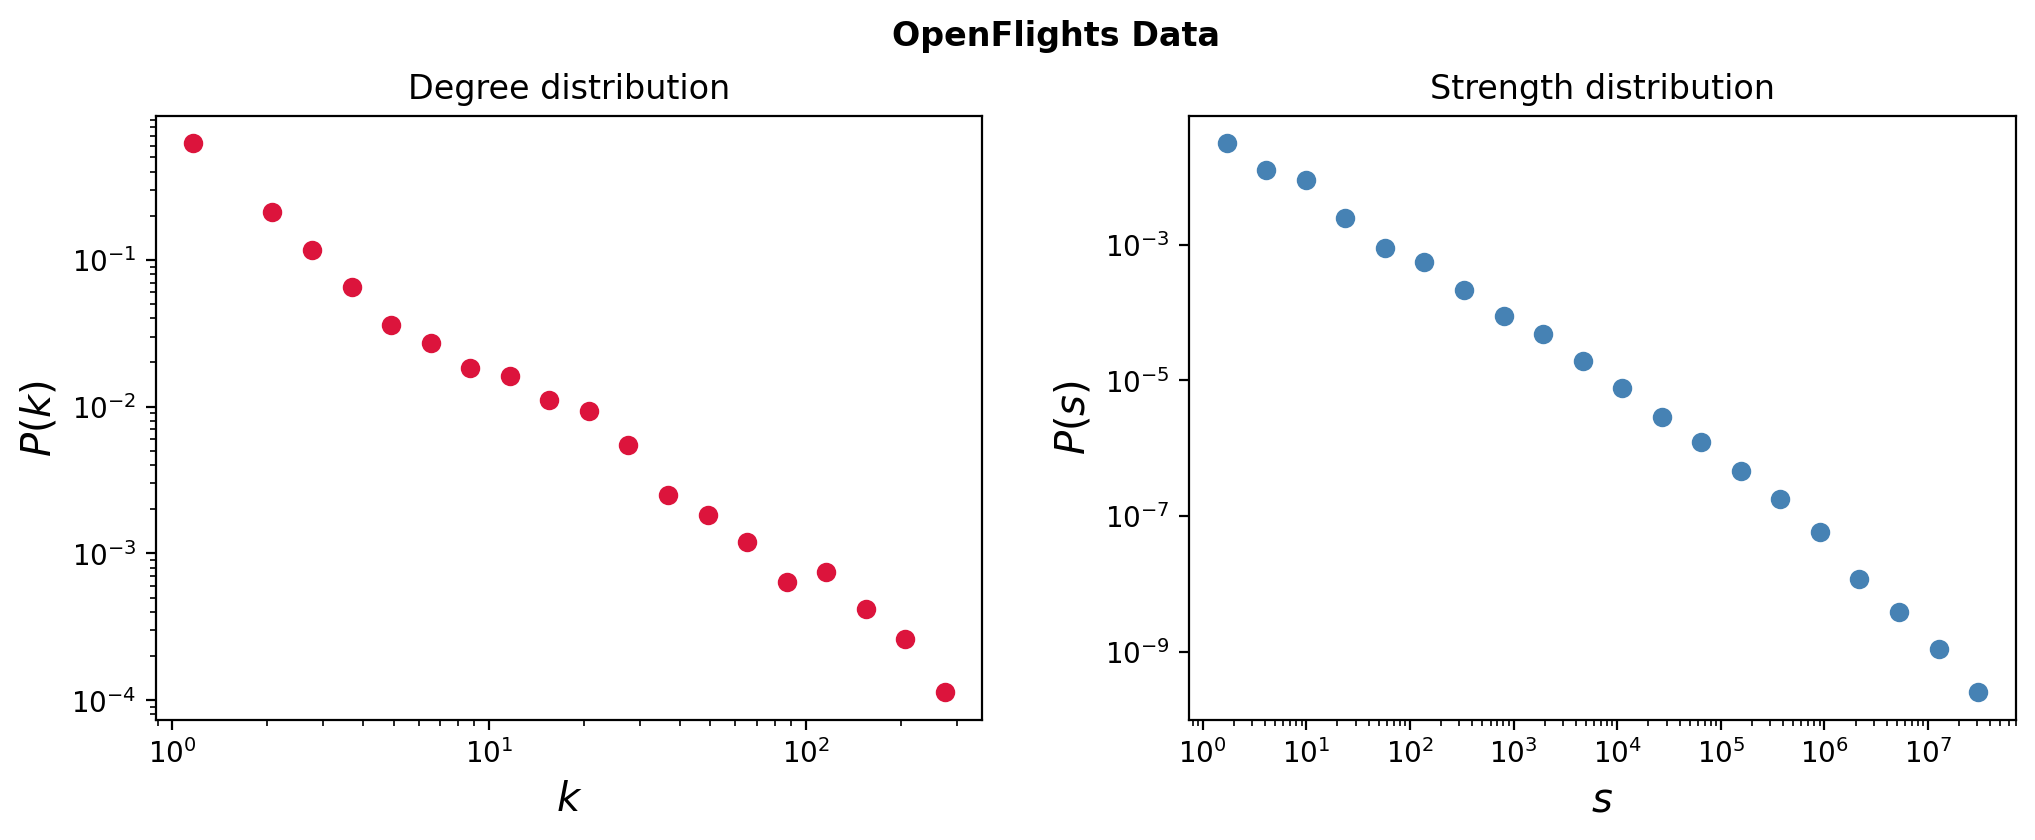

In [106]:
# Plot degree and strength distributions
fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=200)
plt.subplots_adjust(wspace=0.25)

x, y = get_binning(list(dict(G.degree()).values()),
                   num_bins=20, log_binning=True)
ax[0].loglog(x,y,'o',color='crimson')
ax[0].set_ylabel(r'$P(k)$',fontsize='x-large')
ax[0].set_xlabel(r'$k$',fontsize='x-large')
ax[0].set_title('Degree distribution')

x, y = get_binning(list(dict(G.degree(weight='weight')).values()),
                   num_bins=20, log_binning=True)
ax[1].loglog(x,y,'o',color='steelblue')
ax[1].set_ylabel(r'$P(s)$',fontsize='x-large')
ax[1].set_xlabel(r'$s$',fontsize='x-large')
ax[1].set_title('Strength distribution')

plt.suptitle('OpenFlights Data',fontweight='bold',y=1.0)

plt.show()

___________
## Sparsification Method #1: Global Thresholding

One of the most common ways to sparsify a weighted network is to apply a single global threshold on edge weights:

- keep edges with weight $w_{ij} > \tau$,
- drop edges with weight $w_{ij} \le \tau$.

This kind of **global thresholding** is easy to implement and often appears as a first preprocessing step for correlation networks, co-occurrence networks, or projected bipartite graphs.

However, it comes with serious drawbacks:
- It ignores/destroys heterogeneity in the network. Nodes with very small total strength (or low degrees) are disproportionately likely to lose all their edges when we apply a single global cutoff.
- It ignores local multi-scale structure. A single value of $\tau$ cannot preserve both strong ties between hubs and weaker—but locally important—ties between low-strength nodes.
- It tends to distort degree and strength distributions in ways that are hard to control, especially when edge weights span several orders of magnitude and lack a characteristic scale.

In the code below we implement a simple thresholding function and then explore how gradually increasing the weight threshold reshapes the degree and edge weight distributions of a weighted graph.

### Your turn!

In [ ]:
def threshold_graph(G, threshold, weight_key='weight'):
    """
    Return a globally thresholded version of a weighted graph.

    The function constructs a new graph H on (optionally) the same node set as G
    and keeps only those edges whose weight exceeds a global threshold.

    Parameters:
        G: A NetworkX graph with edge weights stored under `weight_key`.
        threshold: Global cutoff value. Only edges with weight > threshold
            are retained.
        weight_key: the key that weights are stored in (standard nx is 'weight')

    Returns:
        G_thresh: A new NetworkX graph containing the thresholded edge set.
    """
    H = G.copy()
    saved_nodes = []
    for node in H.nodes():
        for neighbor in H.neighbors(node):
            
            
    



    pass
    
    G_thresh = nx.subgraph(H, saved_nodes)

    return G_thresh

__________

In [142]:
def threshold_graph(G, threshold, weight_key="weight", copy_nodes=True):
    """
    Return a globally thresholded version of a weighted graph.

    The function constructs a new graph H on (optionally) the same node set as G
    and keeps only those edges whose weight exceeds a global threshold.

    Parameters:
        G: A NetworkX graph with edge weights stored under `weight_key`.
        threshold: Global cutoff value. Only edges with weight > threshold
            are retained.
        weight_key: Name of the edge attribute used as weight (default: "weight").
        copy_nodes: If True, copy all nodes (and their attributes) from G into H
            even if they become isolated. If False, only nodes incident to
            retained edges will appear in H.

    Returns:
        H: A new NetworkX graph containing the thresholded edge set.
    """
    H = G.__class__()  # preserve directed / undirected type

    if copy_nodes:
        H.add_nodes_from(G.nodes(data=True))

    for u, v, data in G.edges(data=True):
        w = data.get(weight_key)
        if w is None:
            continue
        if w > threshold:
            # keep all existing edge attributes
            H.add_edge(u, v, **data)

    return H

In [143]:
edges = pd.read_csv('data/openflights_USairport_2010.txt', sep=' ', header=None,
                    names=['source','target','weight'])
nodes = pd.read_csv('data/openflights_airports.txt', sep=' ')


w_edge_dict = dict(zip(list(zip(edges['source'],edges['target'])), edges['weight']))

G = nx.Graph()
G.add_nodes_from(nodes['Airport ID'].values)
G.add_edges_from([(int(i),int(j),{'weight':k}) for i,j,k in list(edges.values)])

Gx = nx.subgraph(G, max(nx.connected_components(G), key=len))

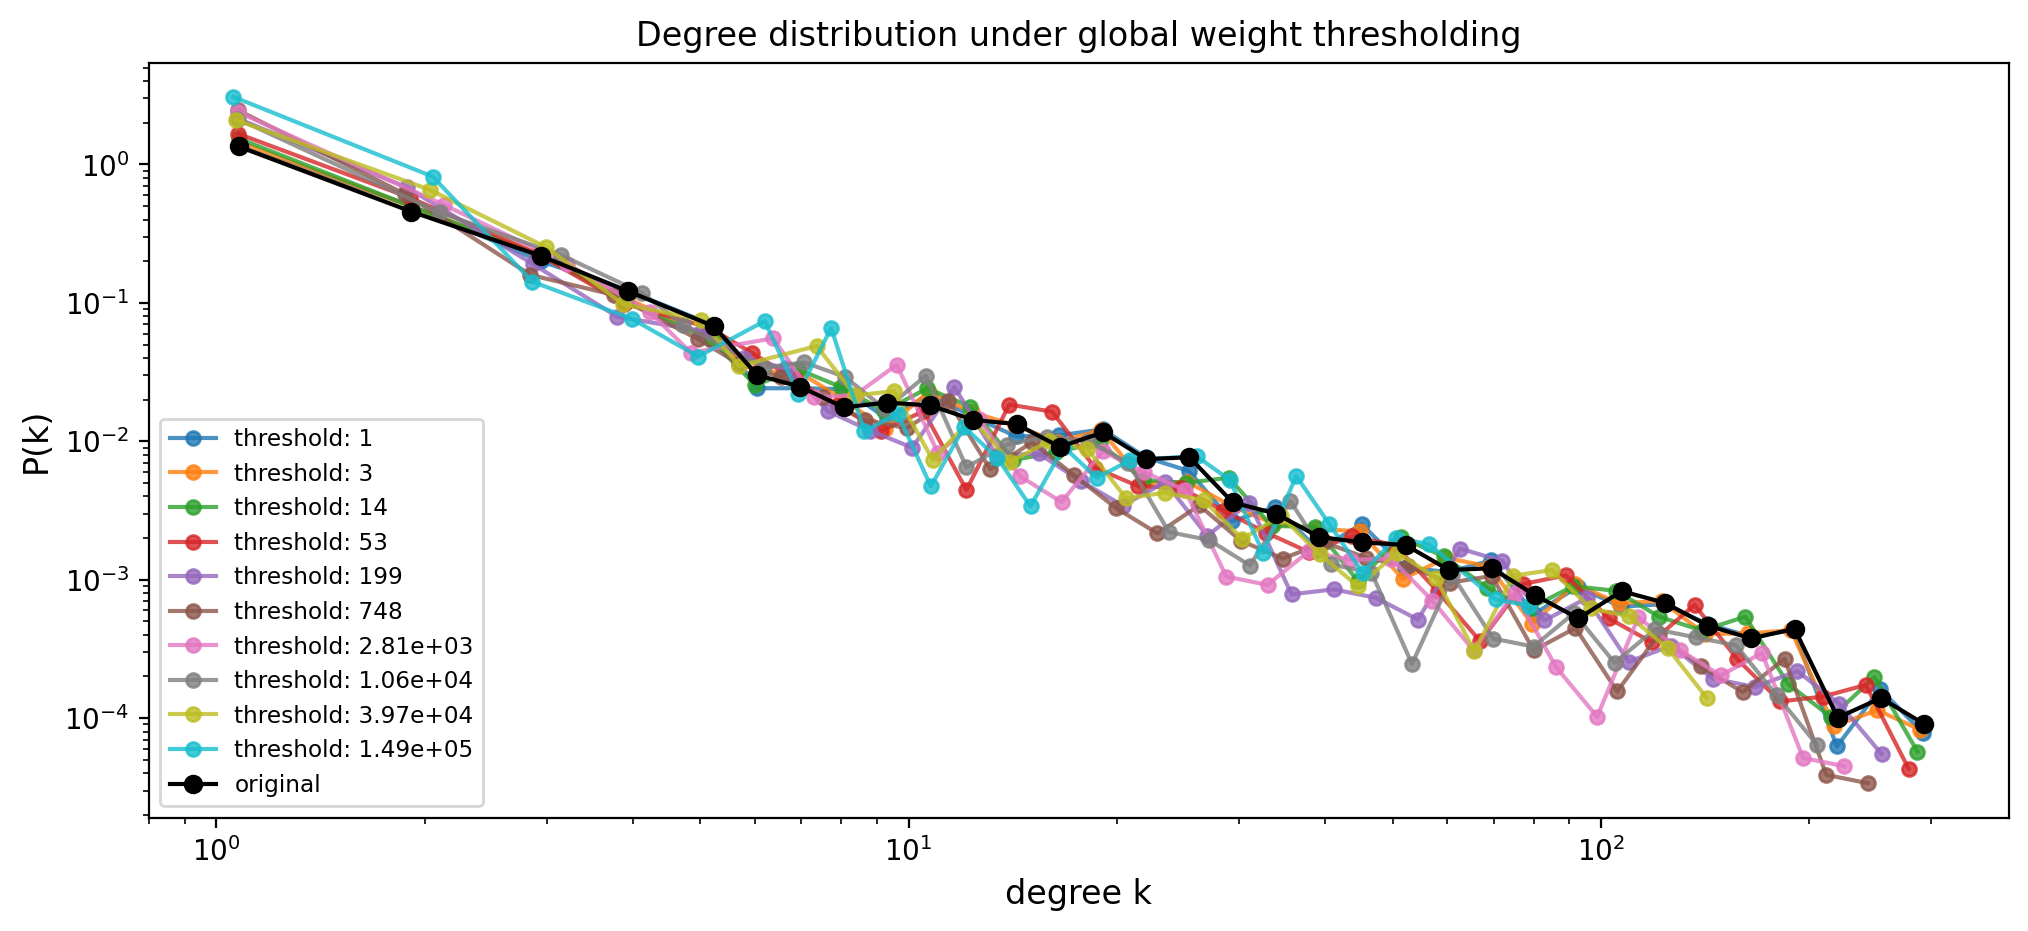

In [144]:
# Collect original edge weights
weights = list(nx.get_edge_attributes(G, "weight").values())
weights = np.array(weights)

min_w = weights.min()
max_w = weights.max()

# Use logarithmically spaced thresholds between min_w and max_w / 10
w_thresholds = np.logspace(np.log10(min_w),
                           np.log10(max_w) - 1,
                           10).astype(int)

fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

for w_threshold in w_thresholds:
    G_filtered = threshold_graph(Gx, w_threshold)
    frac_nodes = 100.0 * G_filtered.number_of_nodes() / float(N)

#     print(f"w_threshold: {w_threshold:.6g} ({frac_nodes:5.2f}% of nodes remain)")

    degrees_filtered = list(dict(G_filtered.degree()).values())
    x, y = get_binning(degrees_filtered, log_binning=True)
    ax.loglog(x, y, "o-", label=f"threshold: {w_threshold:.3g}", ms=5, alpha=0.8)

# Original degree distribution
x_true, y_true = get_binning(list(dict(G.degree()).values()), log_binning=True)
ax.loglog(x_true, y_true, "-o", label="original", color='k')

ax.set_xlabel("degree k", fontsize='large')
ax.set_ylabel("P(k)", fontsize='large')
ax.set_title("Degree distribution under global weight thresholding")
ax.legend(fontsize='small', loc=3)

plt.show()

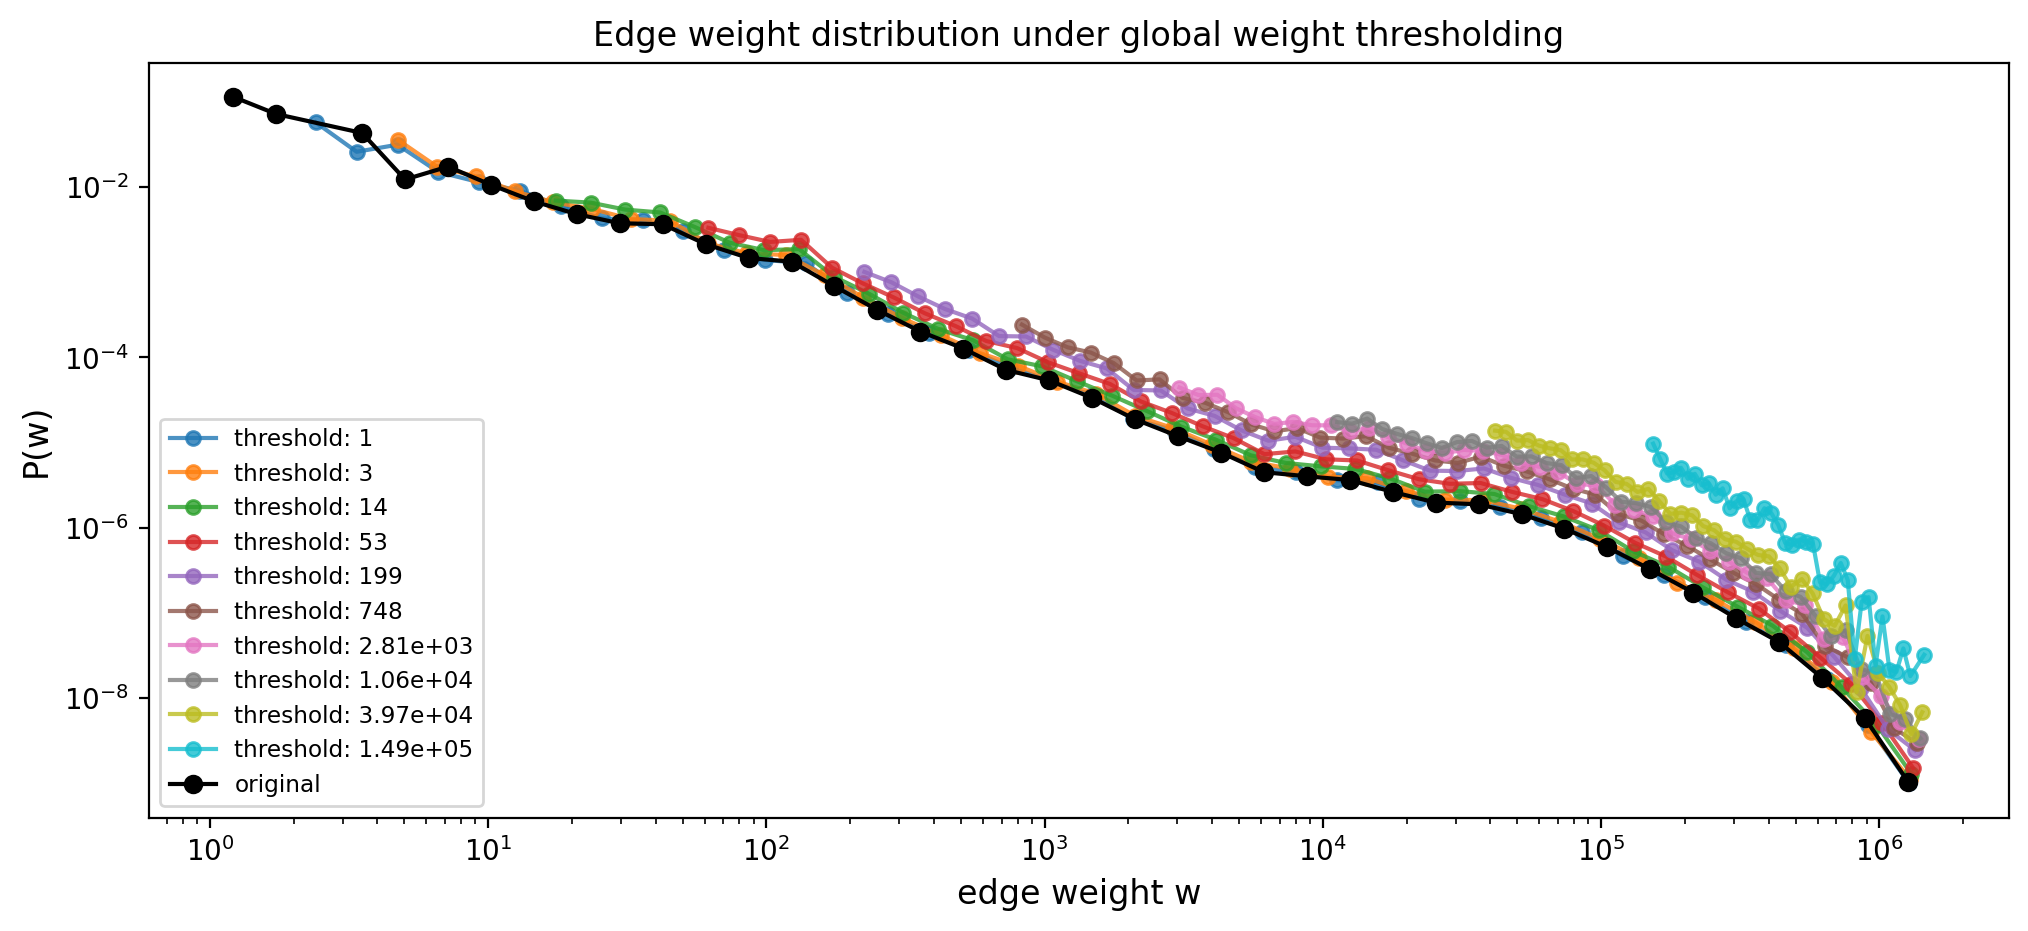

In [145]:
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

for w_threshold in w_thresholds:
    G_filtered = threshold_graph(Gx, w_threshold)
    frac_nodes = 100.0 * G_filtered.number_of_nodes() / float(N)

#     print(f"w_threshold: {w_threshold:.6g} ({frac_nodes:5.2f}% of nodes remain)")

    weights_filtered = list(nx.get_edge_attributes(G_filtered, "weight").values())
    if len(weights_filtered) == 0:
        continue  # nothing left at this threshold

    x, y = get_binning(weights_filtered, log_binning=True)
    ax.loglog(x, y, "o-", label=f"threshold: {w_threshold:.3g}", ms=5, alpha=0.8)

# Original weight distribution
weights_original = list(nx.get_edge_attributes(G, "weight").values())
x_true, y_true = get_binning(weights_original, log_binning=True)
ax.loglog(x_true, y_true, "-o", label="original", color='k')

plt.xlabel("edge weight w", fontsize='large')
plt.ylabel("P(w)", fontsize='large')
plt.title("Edge weight distribution under global weight thresholding")
plt.legend(fontsize='small', loc=3)

plt.show()

### Maybe thresholding is too blunt...
Thresholding really chops off a lot of the network's information

_______
## Sparsification Method: Spanning Trees

A **spanning tree** of a connected graph $G = (V, E)$ is a subgraph $T = (V, E_T)$ that:

1. contains all the nodes of $G$ (it “spans” $V$), and  
2. is a tree, i.e. it is connected and has no cycles.

Every spanning tree has exactly $|V| - 1$ edges. When the graph is weighted, we can look for spanning trees that are optimal with respect to the **sum of edge weights**. This leads to minimum and maximum spanning trees, which are often used as extremely sparse structural backbones.


### Minimum spanning trees

Given a connected weighted graph with edge weights $\{w_{ij}\}$, a **minimum spanning tree** (MinST) is a spanning tree $T$ that minimizes the total weight

$$ W(T) = \sum_{(i,j) \in E_T} w_{ij} $$

over all spanning trees of the graph. If all edge weights are distinct, the minimum spanning tree is unique.

Minimum spanning trees are natural when the edge weight represents a **cost** or **distance**:

- in transportation networks, $w_{ij}$ might be travel time or distance between locations;
- in infrastructure design, $w_{ij}$ can represent construction or maintenance cost.

In these settings, the MinST gives the cheapest way to connect all nodes without cycles. As a sparsification method, a minimum spanning tree is an **extreme** backbone (!!):

- it guarantees global connectivity using only $|V|-1$ edges;
- it typically preserves a rough sense of “short” routes between nodes;
- but it removes almost all redundancy and cycles, so clustering and community structure are nearly destroyed (global clustering coefficient becomes $0$ in a simple tree).

### Maximum spanning trees

When edge weights represent **similarities**, **flows**, or **capacities** (rather than costs), it is often more meaningful to look for a spanning tree that *maximizes* the total weight. A **maximum spanning tree** (sometimes also called a “maximum weight spanning tree”) is a spanning tree $T$ that maximizes

$$ W(T) = \sum_{(i,j) \in E_T} w_{ij}.$$ 

Here, large weights correspond to strong or important connections; the maximum spanning tree therefore selects a single, globally connected backbone built from the strongest available edges, subject to the constraint of having no cycles. As a structural backbone, this has similar pros and cons to the minimum spanning tree:

- the backbone is connected and uses only $|V|-1$ edges;
- it highlights the strongest ties in the network, often forming a “skeleton” that passes through hubs and major pathways;
- but it erases almost all clustering and community structure because trees have no cycles.

One standard way to compute a (minimum or maximum) spanning tree is **Kruskal's algorithm**:

1. Sort all edges by weight (ascending for a minimum spanning tree, descending for a maximum spanning tree).
2. Initialize an empty edge set $E_T$.
3. Consider edges in sorted order. For each edge, add it to $E_T$ **if and only if** it does not create a cycle with the edges already in $E_T$; otherwise discard it.
4. Stop when $|E_T| = |V| - 1$. The resulting subgraph is a spanning tree (minimum or maximum, depending on the sorting order).

We will not reimplement Kruskal’s algorithm here. Instead, we will use the built-in NetworkX routines to compute minimum and maximum spanning trees and then treat them as very sparse backbones for comparison with other sparsification methods.

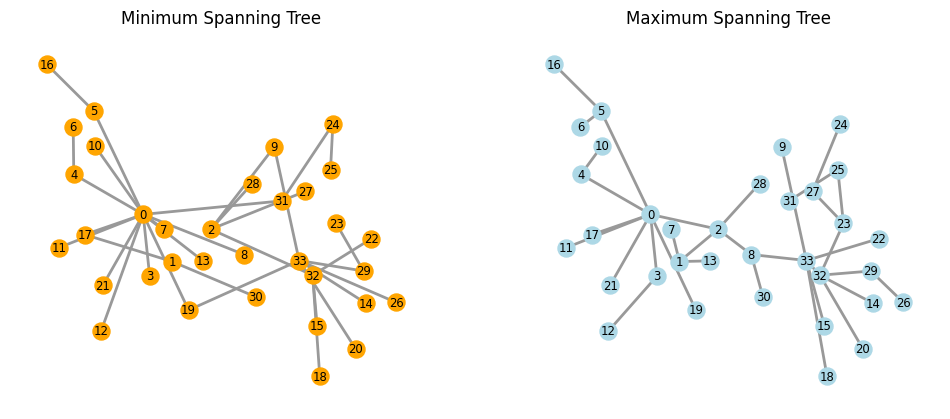

In [146]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

kc_min = nx.minimum_spanning_tree(G, algorithm="kruskal")
nx.draw(kc_min, pos, with_labels=True, node_color="orange", width=2, font_size='small',
        edge_color=".6", ax=ax[0], node_size=150)

kc_max = nx.maximum_spanning_tree(G, algorithm="kruskal")
nx.draw(kc_max, pos, with_labels=True, node_color="lightblue", width=2, font_size='small',
        edge_color=".6", ax=ax[1], node_size=150)

ax[0].set_title("Minimum Spanning Tree")
ax[1].set_title("Maximum Spanning Tree")

plt.show()

### Maybe spanning trees are too *fine*

Are there other techniques that allow for more preservation of **key** important structure?

A sort of Goldilocks sparsification technique...?


### Entering: The Sparsification Wars ;)

tl;dr, there are a ton of ways to do this task, and many of them are effective! We'll go over a few here and reference several others

![](images/backbones.png)

**Image Sources:**
- Kirkley, Alec. "Fast nonparametric inference of network backbones for weighted graph sparsification." *Physical Review X* 15, no. 3 (2025): 031013.
- Glattfelder, J. B. (2012). Backbone of complex networks of corporations: The flow of control. In *Decoding Complexity: Uncovering Patterns in Economic Networks* (pp. 67-93). Berlin, Heidelberg: Springer Berlin Heidelberg.
- https://www.michelecoscia.com/?p=1236
- Mercier, A., Scarpino, S., & Moore, C. (2022). Effective resistance against pandemics: Mobility network sparsification for high-fidelity epidemic simulations. *PLoS Computational Biology*, 18(11).
- Simas, T., Correia, R.B., & Rocha, L.M.. The distance backbone of complex networks. *Journal of Complex Networks*, 9:cnab021, 2021.
- Hmaida, S., Cherifi, H., & El Hassouni, M. (2024). A multilevel backbone extraction framework. *Applied Network Science*, 9(1), 41.

_______

## Sparsification Method: Disparity Filter

Global thresholding applies the same cutoff to all edges, regardless of how large or small a node’s total strength is. The **disparity filter** is a different approach: it uses a *local* null model at each node to identify edges whose weights are unexpectedly large compared to that node’s other connections.

The main idea is to preserve edges that carry a disproportionate fraction of a node's strength, while discarding edges whose weight is compatible with a "random" allocation of strength. In this way, the disparity filter extracts a multi-scale **backbone** of dominant connections that respects the heterogeneity of the network and preserves structural hierarchies even when edge weights span several orders of magnitude.

![](images/disparity_filter.png)

### Step 1: Normalizing edge weights

For a weighted, undirected graph, let $s_i$ denote the **strength** of node $i$ (the sum of weights of its incident edges), and let $w_{ij}$ be the weight of edge $(i,j)$. The first step is to normalize each edge weight by the total strength of its incident node.

For each node $i$ and neighbor $j$ we define the **normalized weight**

$$ p_{ij} = \frac{w_{ij}}{s_i}, $$

so that

$$ \sum_{j \in N(i)} p_{ij} = 1. $$

Intuitively, $p_{ij}$ is the fraction of $i$’s total strength that flows through edge $(i,j)$. Large values of $p_{ij}$ indicate edges that dominate $i$'s connections.


### Step 2: A local null model

Next we define a **null model** for how the normalized weights around a node might look *if there were no particular preference* for any neighbor.

For a node $i$ with degree $k_i$, the null model assumes that the unit interval $[0,1]$ is split into $k_i$ segments by placing $k_i-1$ cut points uniformly at random. The resulting segment lengths $ \{x_1, x_2, \dots, x_{k_i}\} $ represent the normalized weights $\{p_{ij}\}$ under a purely random allocation of strength.

Under this null model, the probability density of a single normalized weight $p$ is

$$ \rho(p) = (k_i - 1)(1 - p)^{k_i - 2}, \quad 0 \le p \le 1. $$

To assess whether an observed $p_{ij}$ is unusually large for node $i$, we compute the **one-sided $p$-value**: the probability that a random segment from this distribution is at least as large as $p_{ij}$,

$$ \alpha_{ij} = \Pr\big(X \ge p_{ij}\big)
               = 1 - (k_i - 1)\int_0^{p_{ij}} (1 - x)^{k_i - 2}\,dx
               = (1 - p_{ij})^{k_i - 1}.$$

Small values of $\alpha_{ij}$ mean that it is very unlikely, under the null model, to see a normalized weight as large as $p_{ij}$ purely by chance.

### Step 3: Choosing a significance level and defining the backbone

We now select a **significance level** $\alpha$ (for example, $\alpha = 0.05$). For each edge $(i,j)$ we test the null model at each endpoint:

- compute $\alpha_{ij}$ using node $i$’s degree and strength,
- compute $\alpha_{ji}$ using node $j$’s degree and strength.

An edge is considered **statistically significant** for node $i$ if

$$ \alpha_{ij} < \alpha,$$

and similarly for node $j$. The edge $(i,j)$ is included in the backbone if it is significant for **at least one** of its endpoints.
_________

#### A few details:

- Nodes with degree $k_i = 1$ have no heterogeneity to test (there is only a single edge), so the null model is not very informative. In practice, the usual convention is:
  - if one endpoint has $k > 1$ and the other has $k = 1$, we only test significance using the endpoint with $k > 1$;
  - edges between two degree-1 nodes can be kept or discarded by convention, since they do not affect local heterogeneity.

By construction, the disparity filter uses *different* effective thresholds for different nodes, depending on their degree and strength. This allows it to preserve significant edges of low-strength nodes (which would be wiped out by a global threshold) and to retain only the most dominant edges of high-degree, high-strength hubs.


![](images/disparity_filter2.png)

In [147]:
def disparity_filter(G, alpha, weight_key="weight", copy_nodes=False):
    """
    Extract a disparity-filter backbone from a weighted, undirected graph.

    For each node n with degree k_n > 1, the function:
      1. Computes its strength
            s_n = sum_j w_{nj},
         where w_{nj} is the weight of edge (n, j).
      2. Computes normalized weights
            p_{nj} = w_{nj} / s_n.
      3. Evaluates the disparity-filter p-value
            alpha_{nj} = (1 - p_{nj})^(k_n - 1).
      4. If alpha_{nj} < alpha, the edge (n, j) is considered significant
         from n's perspective and is added to the backbone.

    Because we loop over all nodes, an undirected edge (i, j) can be added
    from either endpoint's perspective. In practice, this means edges that
    are significant for at least one endpoint are kept.

    Args:
        G: NetworkX graph. Assumed undirected, with positive edge weights.
        alpha: Significance level in (0, 1). Smaller alpha → sparser backbone.
        weight_key: Name of the edge attribute containing weights (default "weight").
        copy_nodes: If True, copy all nodes (and their attributes) from G
            into the backbone graph.

    Returns:
        keep_graph: A new NetworkX graph containing the backbone edges.
                    Node attributes (if copy_nodes=True) and edge attributes,
                    including weights, are preserved.
    """
    keep_graph = G.__class__()

    if copy_nodes:
        keep_graph.add_nodes_from(G.nodes(data=True))

    # Loop over all nodes in the original graph
    for n in G.nodes():
        neighbors = list(G[n])
        k_n = len(neighbors)

        # Nodes with degree <= 1 do not contribute to the disparity test
        if k_n <= 1:
            continue

        # Total strength s_n of node n
        sum_w = 0.0
        for nj in neighbors:
            sum_w += G[n][nj][weight_key]

        if sum_w <= 0:
            # If total strength is non-positive, skip this node
            continue

        # Examine each neighbor and test significance of the normalized weight
        for nj in neighbors:
            w_nj = G[n][nj][weight_key]
            p_nj = w_nj / sum_w  # normalized weight p_{nj}

            # Disparity-filter p-value: alpha_{nj} = (1 - p_{nj})^(k_n - 1)
            p_value = (1.0 - p_nj) ** (k_n - 1)

            # If p-value is below the chosen significance level, keep the edge
            if p_value < alpha:
                # Copy all edge attributes (including weight)
                edge_data = G[n][nj]
                keep_graph.add_edge(n, nj, **edge_data)

    return keep_graph

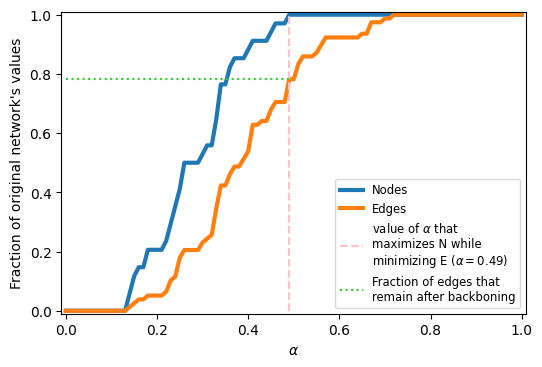

In [149]:
alphas = np.linspace(0,1,101)
G = nx.karate_club_graph()

N_vals = []
E_vals = []

for a in alphas:
    G_i = disparity_filter(G, a)
    N_vals.append(G_i.number_of_nodes()/\
                  G.number_of_nodes())
    E_vals.append(G_i.number_of_edges()/\
                  G.number_of_edges())
    

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
ax.plot(alphas, N_vals, label='Nodes', lw=3)
ax.plot(alphas, E_vals, label='Edges', lw=3)

ideal_val_index = np.where(np.array(N_vals)==1.0)[0][0]
ax.vlines(alphas[ideal_val_index],0,1,color='pink',ls='--',
          label=r'value of $\alpha$ that'+'\nmaximizes N while'+'\nminimizing E '+\
                r'($\alpha=%.2f$)'%alphas[ideal_val_index])

ax.hlines(E_vals[ideal_val_index], 0, alphas[ideal_val_index], color='limegreen',
          ls=':', label='Fraction of edges that\nremain after backboning')

ax.legend(fontsize='small')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Fraction of original network's values")
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

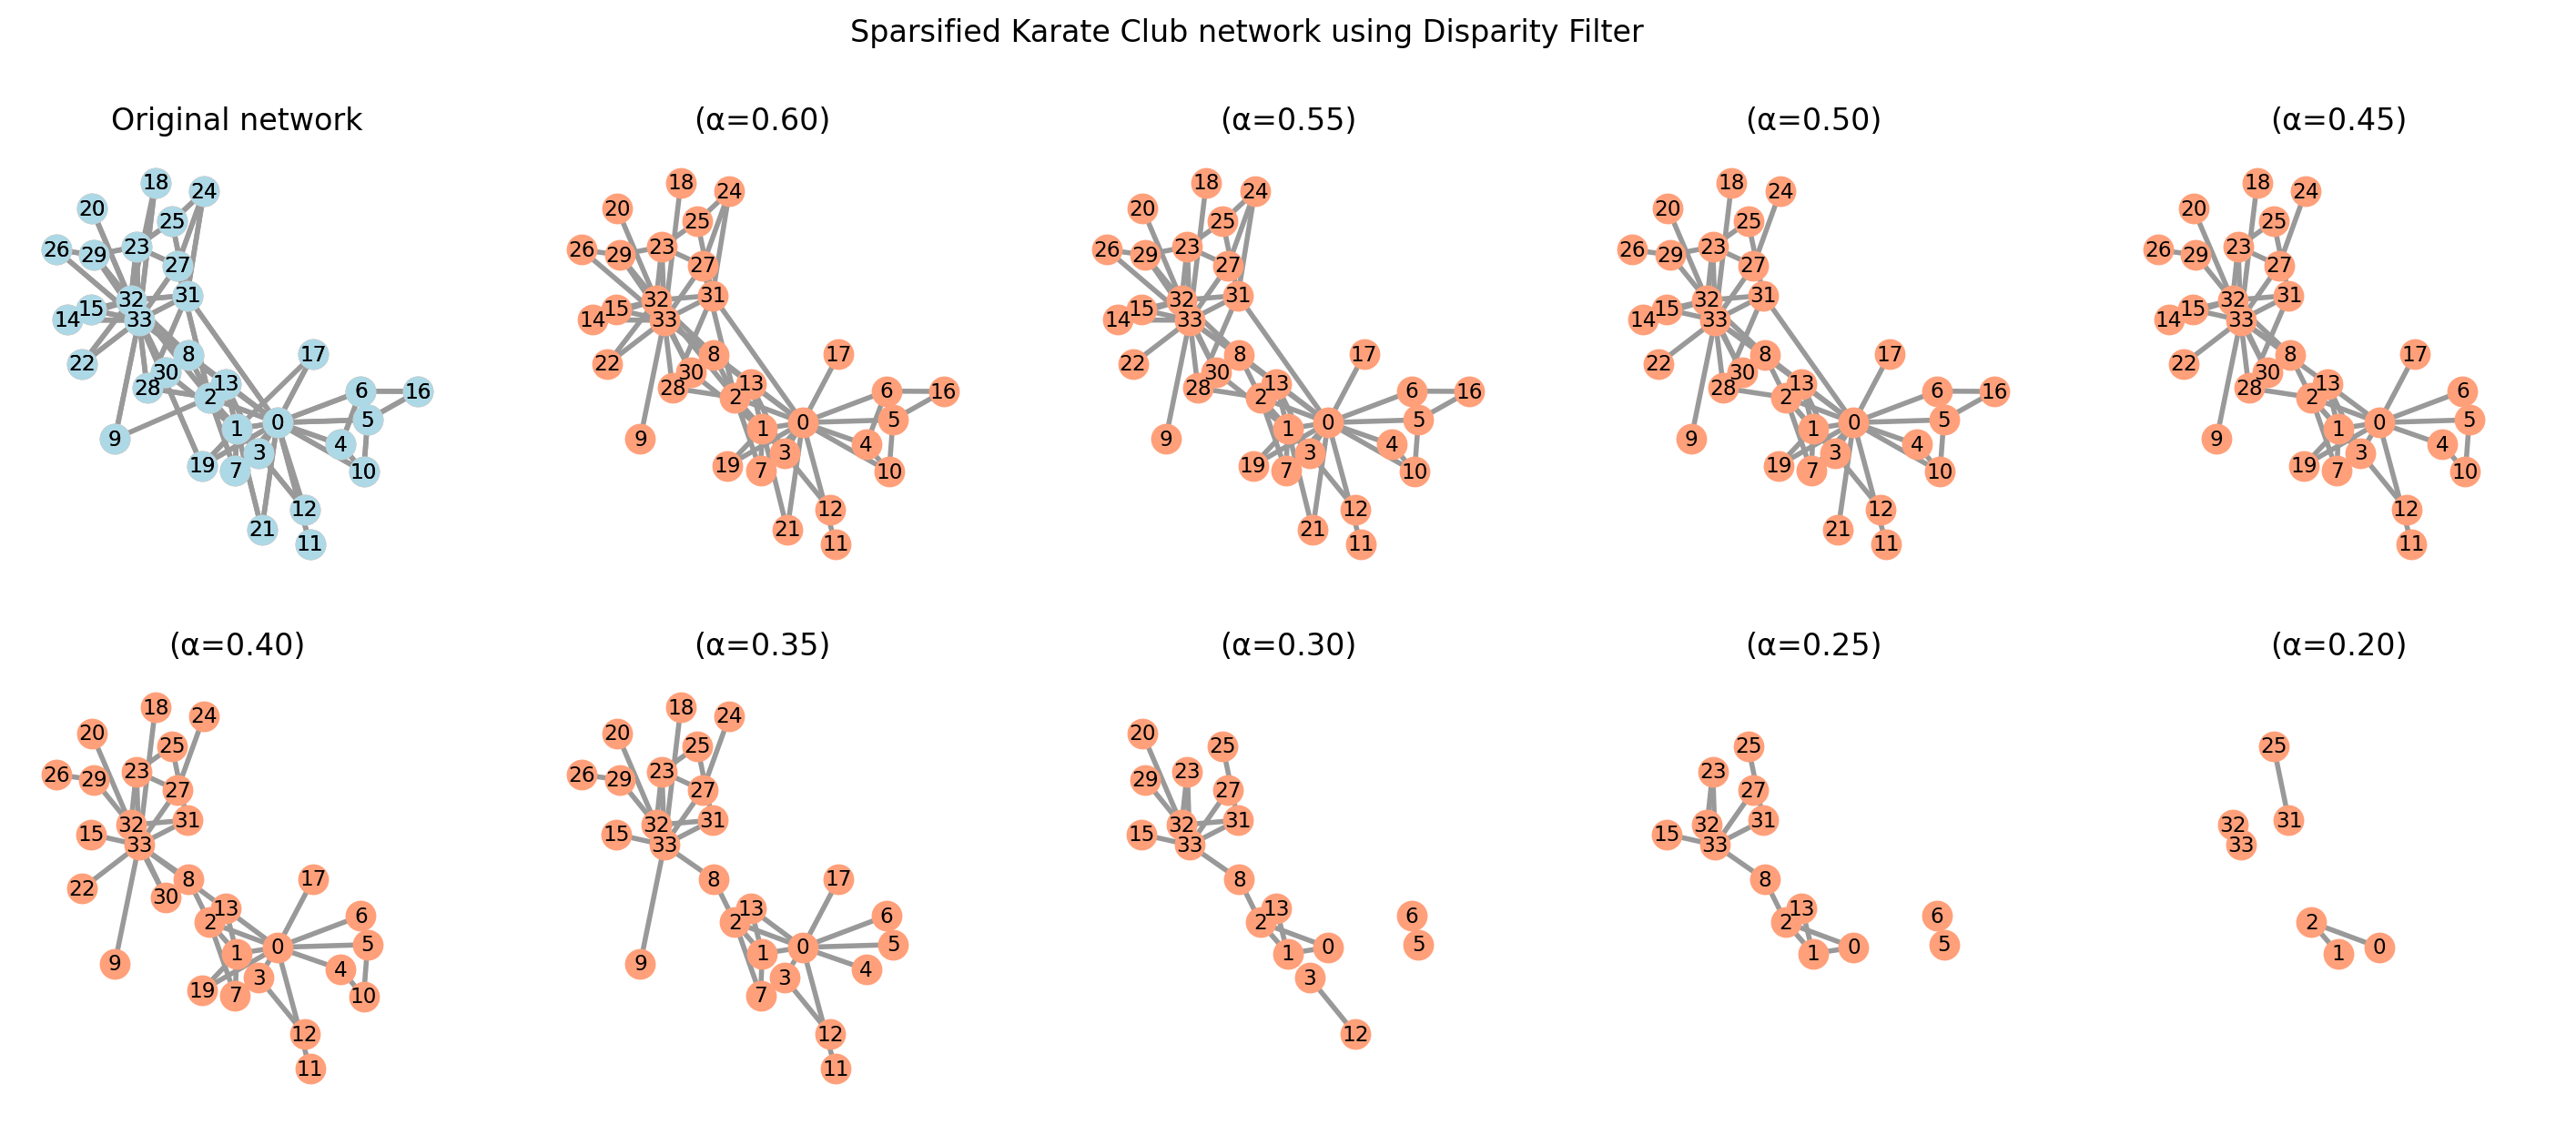

In [150]:
sparsified_graphs = {}
alphas = np.arange(0.2, 0.7, 0.05)

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True, dpi=200) 

for i, alpha in enumerate(alphas):
    sparsified_graphs[alpha] = disparity_filter(G, alpha)
    
    nx.draw(sparsified_graphs[alpha], pos=positions, ax=axes.flat[-(i + 1)], 
            with_labels=True, node_color="lightsalmon", edge_color=".6", width=2,
            node_size=125, font_size='small')
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.2f})")

# Original network
nx.draw(G, pos=positions, ax=axes.flat[0], with_labels=True, node_color="lightblue",
        edge_color=".6", width=2, node_size=125, font_size='small')
axes.flat[0].set_title("Original network")


plt.suptitle("Sparsified Karate Club network using Disparity Filter")


plt.show()

In [151]:
edges = pd.read_csv('data/openflights_USairport_2010.txt', sep=' ', header=None,
                    names=['source','target','weight'])
nodes = pd.read_csv('data/openflights_airports.txt', sep=' ')


w_edge_dict = dict(zip(list(zip(edges['source'],
                                edges['target'])), 
                       edges['weight']))

G = nx.Graph()
G.add_nodes_from(nodes['Airport ID'].values)
G.add_edges_from([(int(i),int(j),
                   {'weight':k})
                  for i,j,k in list(edges.values)])

Gx = nx.subgraph(G, max(nx.connected_components(G), key=len))

In [152]:
alphas = np.linspace(0,1,101)

N_vals = []
E_vals = []

for a in alphas:
    G_i = disparity_filter(Gx, a)
    N_vals.append(G_i.number_of_nodes()/\
                  Gx.number_of_nodes())
    E_vals.append(G_i.number_of_edges()/\
                  Gx.number_of_edges())

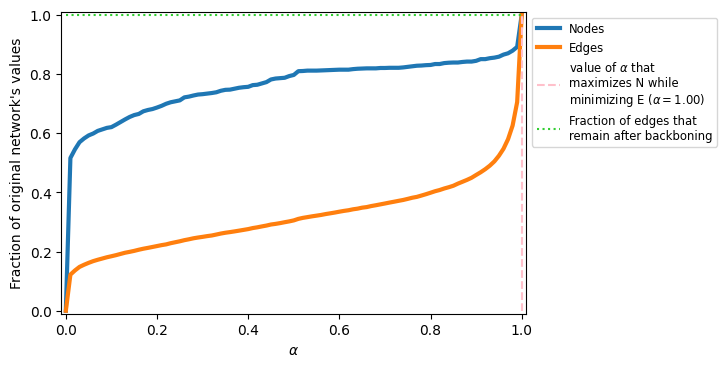

In [153]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
ax.plot(alphas, N_vals, label='Nodes', lw=3)
ax.plot(alphas, E_vals, label='Edges', lw=3)

ideal_val_index = np.where(np.array(N_vals)==1.0)[0][0]
ax.vlines(alphas[ideal_val_index],0,1,color='pink',ls='--',
          label=r'value of $\alpha$ that'+'\nmaximizes N while'+'\nminimizing E '+\
                r'($\alpha=%.2f$)'%alphas[ideal_val_index])

ax.hlines(E_vals[ideal_val_index], 0, alphas[ideal_val_index], color='limegreen',
          ls=':', label='Fraction of edges that\nremain after backboning')

ax.legend(fontsize='small', loc=2, bbox_to_anchor=[1.0,1.0])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Fraction of original network's values")
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

![](images/disparity_filter3.png)

_________

## Sparsification Method: Marginal Likelihood Filter

The Marginal Likelihood Filter (MLF) is another statistical backbone extraction method for weighted networks. Whereas the disparity filter evaluates each edge from the local perspective of a single node, the MLF uses a global configuration model style null that depends on the strengths of both endpoints. This makes it more sensitive to edges that are unexpectedly strong given the strengths of the two nodes they connect.

**Source:** Dianati, N. (2016). Unwinding the hairball graph: Pruning algorithms for weighted complex networks. *Physical Review E*, 93(1), 012304. http://doi.org/10.1103/PhysRevE.93.012304

![](images/mlf.png)

### Mathematical framework for the MLF

Assume we have an undirected weighted graph where edge weights $w_{ij}$ are non-negative integers counting discrete events (flights between airports, co-occurrences of words, etc.). Let $ s_i = \sum_j w_{ij} $  be the (integer) strength of node $i$, and let $ T = \sum_{i<j} w_{ij} $ be the total number of unit edge contributions in the network.

The MLF null model imagines that these $T$ unit contributions are assigned independently to unordered node pairs $(i,j)$, with probabilities proportional to the product of their strengths. Under this model, the probability that a single unit chooses the pair $(i,j)$ is

$$ p_{ij} = \frac{s_i s_j}{2 T^2},$$

so the total weight $\sigma_{ij}$ realized on edge $(i,j)$ follows a binomial distribution

$$ \Pr\big[\sigma_{ij} = m \,\big|\, s_i, s_j, T\big] = \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m}, \qquad m = 0,1,\dots,T. $$

Given an observed edge weight $w_{ij}$, the $p$–value under the null model is the probability of observing a value at least this large by chance: 

$$ P(\sigma_{ij} \ge w_{ij}) = \sum_{m = w_{ij}}^{T} \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m} = 1 - \sum_{m = 0}^{w_{ij}-1} \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m}.$$


As with the disparity filter, we fix a significance level $\alpha$ (for example, $\alpha = 0.01$) and retain edge $(i,j)$ in the backbone if  $P(\sigma_{ij} \ge w_{ij}) \le \alpha$.

Edges that pass this test are those whose observed weight is too large to be explained by the null model that redistributes $T$ unit events at random proportional to node strengths. Because $p_{ij}$ depends on both $s_i$ and $s_j$, the MLF can down-weight edges between very strong nodes (for which large weights are expected) and highlight unexpectedly strong ties involving weaker nodes.

In [25]:
from scipy.stats import binom

def marginal_likelihood_filter(G, alpha, weight_key="weight"):
    """
    Extract the backbone of a weighted, undirected network using the
    Marginal Likelihood Filter (MLF) of Dianati (2016).

    The method assumes integer edge weights w_ij representing counts of
    discrete events (e.g., flights, co-occurrences). Let

        s_i = sum_j w_ij          (strength of node i)
        T   = sum_{i<j} w_ij      (total number of unit edge contributions)

    Under the null model, each of the T unit contributions independently
    chooses an unordered pair (i, j) with probability

        p_ij = s_i * s_j / (2 * T^2),

    so the realized edge weight sigma_ij follows a Binomial(T, p_ij)
    distribution. For each observed edge (i, j) with weight w_ij, the
    p-value is

        p_value = P(sigma_ij >= w_ij)
                = 1 - BinomCDF(w_ij - 1; T, p_ij).

    The backbone keeps only those edges whose p-value is at most alpha.

    Parameters
    ----------
    G : networkx.Graph
        Undirected weighted graph. Edge weights should be non-negative
        integers stored under `weight_key`.
    alpha : float
        Significance level (0 < alpha < 1). Smaller values yield sparser
        backbones.
    weight_key : str, optional
        Name of the edge attribute containing integer weights
        (default: "weight").

    Returns
    -------
    backbone : networkx.Graph
        A graph containing only the edges that pass the Marginal Likelihood
        Filter at the given significance level. Node attributes are copied
        from G, and edge weights are preserved.
    """
    if G.is_directed():
        raise ValueError("marginal_likelihood_filter assumes an undirected graph.")

    # New graph for the backbone; preserve graph type and node attributes
    backbone = G.__class__()
    backbone.add_nodes_from(G.nodes(data=True))

    # Compute node strengths and total weight T = sum_{i<j} w_ij
    strengths = {node: 0.0 for node in G.nodes()}
    T = 0.0

    for u, v, data in G.edges(data=True):
        w_uv = data.get(weight_key, 0.0)
        if w_uv <= 0:
            continue
        strengths[u] += w_uv
        strengths[v] += w_uv
        T += w_uv

    if T <= 0:
        # No positive weights, nothing to do
        return backbone

    # For each edge, compute its binomial p-value under the null model
    for u, v, data in G.edges(data=True):
        w_uv = data.get(weight_key, 0.0)
        if w_uv <= 0:
            continue

        s_u = strengths[u]
        s_v = strengths[v]

        # Edge probability under the null:
        # p_ij = s_i * s_j / (2 * T^2)
        p_ij = (s_u * s_v) / (2.0 * T**2)

        # Numerical safety: clamp p_ij to [0, 1]
        p_ij = max(0.0, min(1.0, p_ij))

        # p-value: P(sigma_ij >= w_uv) = 1 - CDF(w_uv - 1)
        # Note: binom.cdf(k, n, p) = P(X <= k)
        p_value = 1.0 - binom.cdf(w_uv - 1, int(T), p_ij)

        if p_value <= alpha:
            backbone.add_edge(u, v, **data)

    return backbone

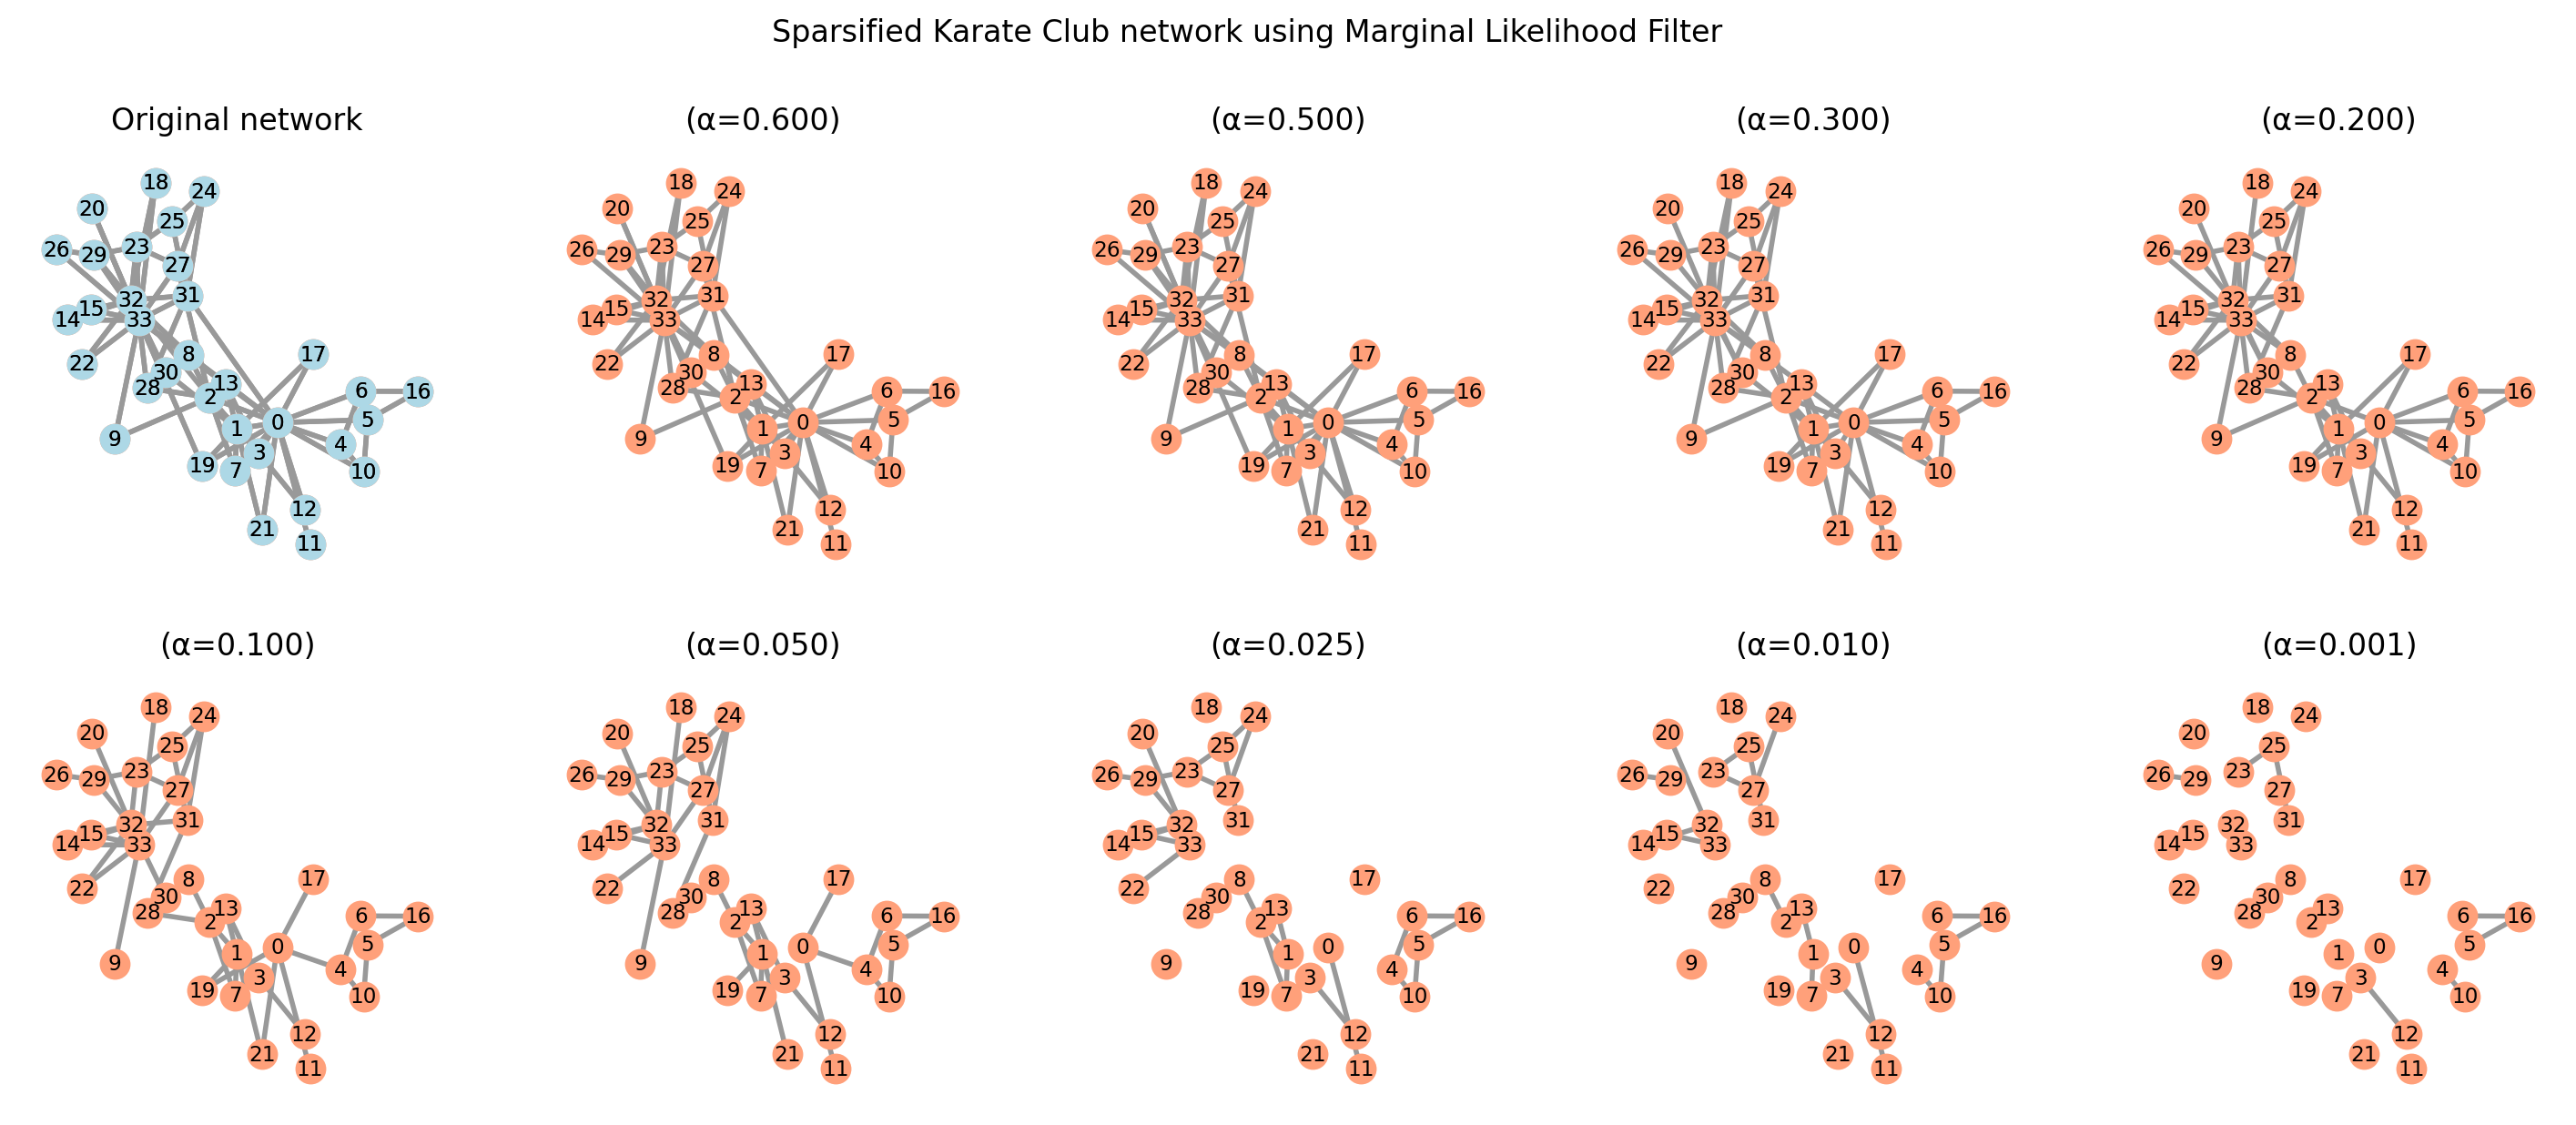

In [26]:
G = nx.karate_club_graph()

sparsified_graphs = {}
alphas = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True, dpi=200) 

for i, alpha in enumerate(alphas[:10]):
    sparsified_graphs[alpha] = marginal_likelihood_filter(G, alpha)

    nx.draw(sparsified_graphs[alpha], pos=positions,  ax=axes.flat[-(i + 1)], 
            with_labels=True, node_color="lightsalmon", edge_color=".6", width=2,
            node_size=125, font_size='small')
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.3f})")

# Original network
nx.draw(G, pos=positions, ax=axes.flat[0], with_labels=True, node_color="lightblue",
        node_size=125, font_size='small', edge_color=".6", width=2)


axes.flat[0].set_title("Original network")
plt.suptitle("Sparsified Karate Club network using Marginal Likelihood Filter")


plt.show()

## Evaluation techniques and applications

Evaluating the performance of backbone extraction methods is essential to ensure their reliability and appropriateness for specific tasks. Below, we will cover t a set of criteria and metrics that can be used to assess the performance of these methods. 

### US domestic flights traffic data 2021-2022

In this section, we will use the domestic nonstop segment of the U.S. airport transportation system for the interval 2021-2022, which can be downloaded from [here](https://www.bts.gov/browse-statistical-products-and-data/bts-publications/data-bank-28ds-t-100-domestic-segment-data).

In [27]:
df = pd.read_table("data/db28seg.dd.wac.2021.2022.asc", sep="|", low_memory=False)
df

year  month origin  origin_city_market_id  origin_wac  \
0       2021      5    01A                  30001           1   
1       2021      8    01A                  30001           1   
2       2022      8    01A                  30001           1   
3       2021      8    01A                  30001           1   
4       2021      9    01A                  30001           1   
...      ...    ...    ...                    ...         ...   
787386  2021      4    ZXU                  36353          15   
787387  2021     12    ZXU                  36353          15   
787388  2022     12    ZXU                  36353          15   
787389  2021      9    ZXU                  36353          15   
787390  2021      4    ZZV                  36361          44   

           origin_city_name dest  dest_city_market_id  dest_wac  \
0          Afognak Lake, AK  A43                30056         1   
1          Afognak Lake, AK  A43                30056         1   
2          Afognak Lake, AK  A43                30056         1   
3          Afognak Lake, AK  A43                30056         1   
4          Afognak Lake, AK  A43                30056         1   
...                     ...  ...                  ...       ...   
787386  North Kingstown, RI  TEB                35167        21   
787387  North Kingstown, RI  TEB                35167        21   
787388  North Kingstown, RI  TEB                35167        21   
787389  North Kingstown, RI  TEB                35167        21   
787390       Zanesville, OH  SAT                33214        74   

           dest_city_name  ... departures_scheduled payload  seats  \
0       Kodiak Island, AK  ...                    0    1200      6   
1       Kodiak Island, AK  ...                    0     750      5   
2       Kodiak Island, AK  ...                    0    2400     12   
3       Kodiak Island, AK  ...                    0    2400     12   
4       Kodiak Island, AK  ...                    0    6000     30   
...                   ...  ...                  ...     ...    ...   
787386      Teterboro, NJ  ...                    0    3450      8   
787387      Teterboro, NJ  ...                    0    3450      8   
787388      Teterboro, NJ  ...                    0    3450      8   
787389      Teterboro, NJ  ...                    0    3450      8   
787390    San Antonio, TX  ...                    0    2500      8   

        passengers freight  mail  ramp_to_ramp  air_time  Wac  Unnamed: 28  
0                1       0     0            20        18    1          NaN  
1                1       0     0            30        28    1          NaN  
2                7       0     0            47        43    1          NaN  
3                2       0     0            43        39    1          NaN  
4                0       0     0           105        95    1          NaN  
...            ...     ...   ...           ...       ...  ...          ...  
787386           1       0     0            72        54   10          NaN  
787387           1       0     0            54        36   10          NaN  
787388           1       0     0            54        42   10          NaN  
787389           1       0     0            54        42   10          NaN  
787390           3       0     0           202       194   54          NaN  

[787391 rows x 29 columns]

In [28]:
print("Number of unique origin airports", len(df["origin"].unique()))
print("Number of unique destination airports", len(df["dest"].unique()))
print()
print("Columns:", [column for column in df.columns])

Number of unique origin airports 1547
Number of unique destination airports 1544

Columns: ['year', 'month', 'origin', 'origin_city_market_id', 'origin_wac', 'origin_city_name', 'dest', 'dest_city_market_id', 'dest_wac', 'dest_city_name', 'Carrier', 'Carrier_Entity', 'carrier_group', 'distance', 'Svc_Class', 'Aircraft_Group', 'Aircraft_type', 'Aircraft_Config', 'departures_performed', 'departures_scheduled', 'payload', 'seats', 'passengers', 'freight', 'mail', 'ramp_to_ramp', 'air_time', 'Wac', 'Unnamed: 28']


In [29]:
df["route"] = df.apply(lambda row: tuple(sorted([row["origin"], row["dest"]])), axis=1)
edges = df.groupby("route")["passengers"].sum().reset_index()
edges[["airport_1", "airport_2"]] = pd.DataFrame(edges["route"].tolist(), index=edges.index)
edges = edges.drop(columns=["route"])
edges = edges.loc[edges["passengers"] > 0]
edges = edges.loc[edges["airport_1"] != edges["airport_2"]]
edges.sort_values(by="passengers", ascending=False)

passengers airport_1 airport_2
20617     4823868       JFK       LAX
3523      4774008       ATL       MCO
3458      4467829       ATL       FLL
21518     4326505       LAS       LAX
12428     4181994       DEN       PHX
...           ...       ...       ...
7273            1       BOS       MQY
20918           1       KCQ       ORI
6399            1       BKG       BTL
1714            1       AGN       EXI
26220           1       PAE       SUN

[20607 rows x 3 columns]

Now, in order to produce some nice visualizations, nothing better than use the real coordinates of each airport. However, this is contained on a separate dataset, can also be downloaded [here](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLL&QO_fu146_anzr=) [7].

In [30]:
unique_airports = pd.concat([edges["airport_1"], edges["airport_2"]]).unique()
print("Number of unique airports", len(unique_airports))
airport_coords = pd.read_csv("data/airport_coords.csv")
airport_coords = airport_coords[airport_coords["AIRPORT"].isin(unique_airports)].drop_duplicates(subset="AIRPORT", keep="first")
airport_coords

Number of unique airports 1501


AIRPORT_SEQ_ID  AIRPORT_ID AIRPORT     DISPLAY_AIRPORT_NAME  \
0             1000101       10001     01A     Afognak Lake Airport   
3             1000501       10005     05A     Little Squaw Airport   
4             1000601       10006     06A             Kizhuyak Bay   
7             1000901       10009     09A          Augustin Island   
8             1001001       10010     1B1          Columbia County   
...               ...         ...     ...                      ...   
19991         1697401       16974     MD3           Harford County   
19996         1697601       16976     MLJ  Baldwin County Regional   
20000         1697901       16979     MS6   Columbia Marion County   
20004         1698201       16982     2AK                Deer Park   
20007         1698501       16985     A9K      Era Denali Heliport   

      DISPLAY_AIRPORT_CITY_NAME_FULL  AIRPORT_WAC AIRPORT_COUNTRY_NAME  \
0                   Afognak Lake, AK            1        United States   
3                   Little Squaw, AK            1        United States   
4                       Kizhuyak, AK            1        United States   
7                          Homer, AK            1        United States   
8                         Hudson, NY           22        United States   
...                              ...          ...                  ...   
19991                Churchville, MD           35        United States   
19996              Milledgeville, GA           34        United States   
20000                   Columbia, MS           53        United States   
20004                   Deerpark, AK            1        United States   
20007                      Healy, AK            1        United States   

      AIRPORT_COUNTRY_CODE_ISO AIRPORT_STATE_NAME AIRPORT_STATE_CODE  ...  \
0                           US             Alaska                 AK  ...   
3                           US             Alaska                 AK  ...   
4                           US             Alaska                 AK  ...   
7                           US             Alaska                 AK  ...   
8                           US           New York                 NY  ...   
...                        ...                ...                ...  ...   
19991                       US           Maryland                 MD  ...   
19996                       US            Georgia                 GA  ...   
20000                       US        Mississippi                 MS  ...   
20004                       US             Alaska                 AK  ...   
20007                       US             Alaska                 AK  ...   

        LATITUDE  LON_DEGREES LON_HEMISPHERE  LON_MINUTES  LON_SECONDS  \
0      58.109444        152.0              W         54.0         24.0   
3      67.570000        148.0              W         11.0          2.0   
4      57.745278        152.0              W         52.0         58.0   
7      59.362778        153.0              W         25.0         50.0   
8      42.288889         73.0              W         42.0         37.0   
...          ...          ...            ...          ...          ...   
19991  39.566944         76.0              W         12.0          9.0   
19996  33.154167         83.0              W         14.0         29.0   
20000  31.297778         89.0              W         48.0         41.0   
20004  56.519722        134.0              W         40.0         46.0   
20007  63.738333        148.0              W         52.0         54.0   

        LONGITUDE     AIRPORT_START_DATE      AIRPORT_THRU_DATE  \
0     -152.906667   7/1/2007 12:00:00 AM                    NaN   
3     -148.183889   8/1/2007 12:00:00 AM                    NaN   
4     -152.882778  10/1/2007 12:00:00 AM                    NaN   
7     -153.430556   6/1/2008 12:00:00 AM                    NaN   
8      -73.710278   4/1/2009 12:00:00 AM  6/30/2011 12:00:00 AM   
...           ...                    ...                    .

In [31]:
airport_network = nx.Graph()
for _, row in edges.iterrows():
    airport_network.add_edge(row['airport_1'], row['airport_2'], weight=row['passengers'])
airport_network.remove_node("DQG") # No coordinates for this airport

print("Number of nodes", len(airport_network))
print("Number of edges", len(airport_network.edges))

Number of nodes 1500
Number of edges 20598


In [32]:
pos  = airport_coords.set_index('AIRPORT')[['LONGITUDE', 'LATITUDE']].apply(tuple, axis=1).to_dict()

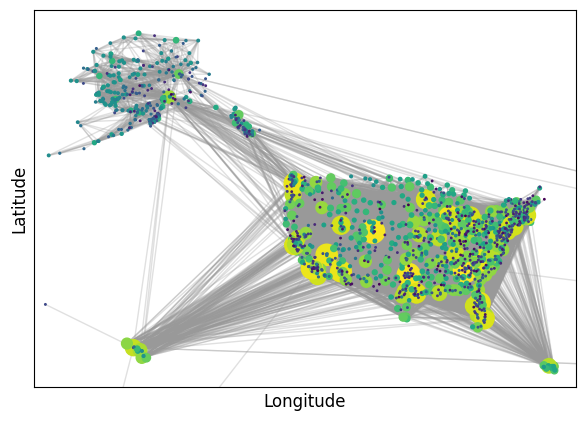

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

node_strength = {node: sum(weight for _, _, weight in airport_network.edges(node, data="weight"))
                 for node in airport_network.nodes}
node_sizes = np.array([2 + 0.05 * np.sqrt(node_strength[node]) for node in airport_network.nodes])/2
node_colors = [np.log10(node_strength[node]) for node in airport_network.nodes]
edge_weights = [np.log10(airport_network[u][v]["weight"]) for u, v in airport_network.edges]

nx.draw_networkx_nodes(airport_network, pos=pos, node_color=node_colors, 
                       node_size=node_sizes, cmap=plt.cm.viridis, ax=ax)

nx.draw_networkx_edges(airport_network, pos=pos, alpha=0.3, edge_color=".6", ax=ax)


ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_xlim(-180, -60) 
ax.set_ylim(15, 75) 


plt.show()

As we can see, the visualization is not very informative. We can observer some hubs, but it is not possible to observer any useful details. Now, let's try with a sparsified version.

<ipython-input-34-84a10d480fe8>:18: RuntimeWarning: divide by zero encountered in log10
  node_colors = [np.log10(node_strength[node]) for node in airport_network_sparsified.nodes]


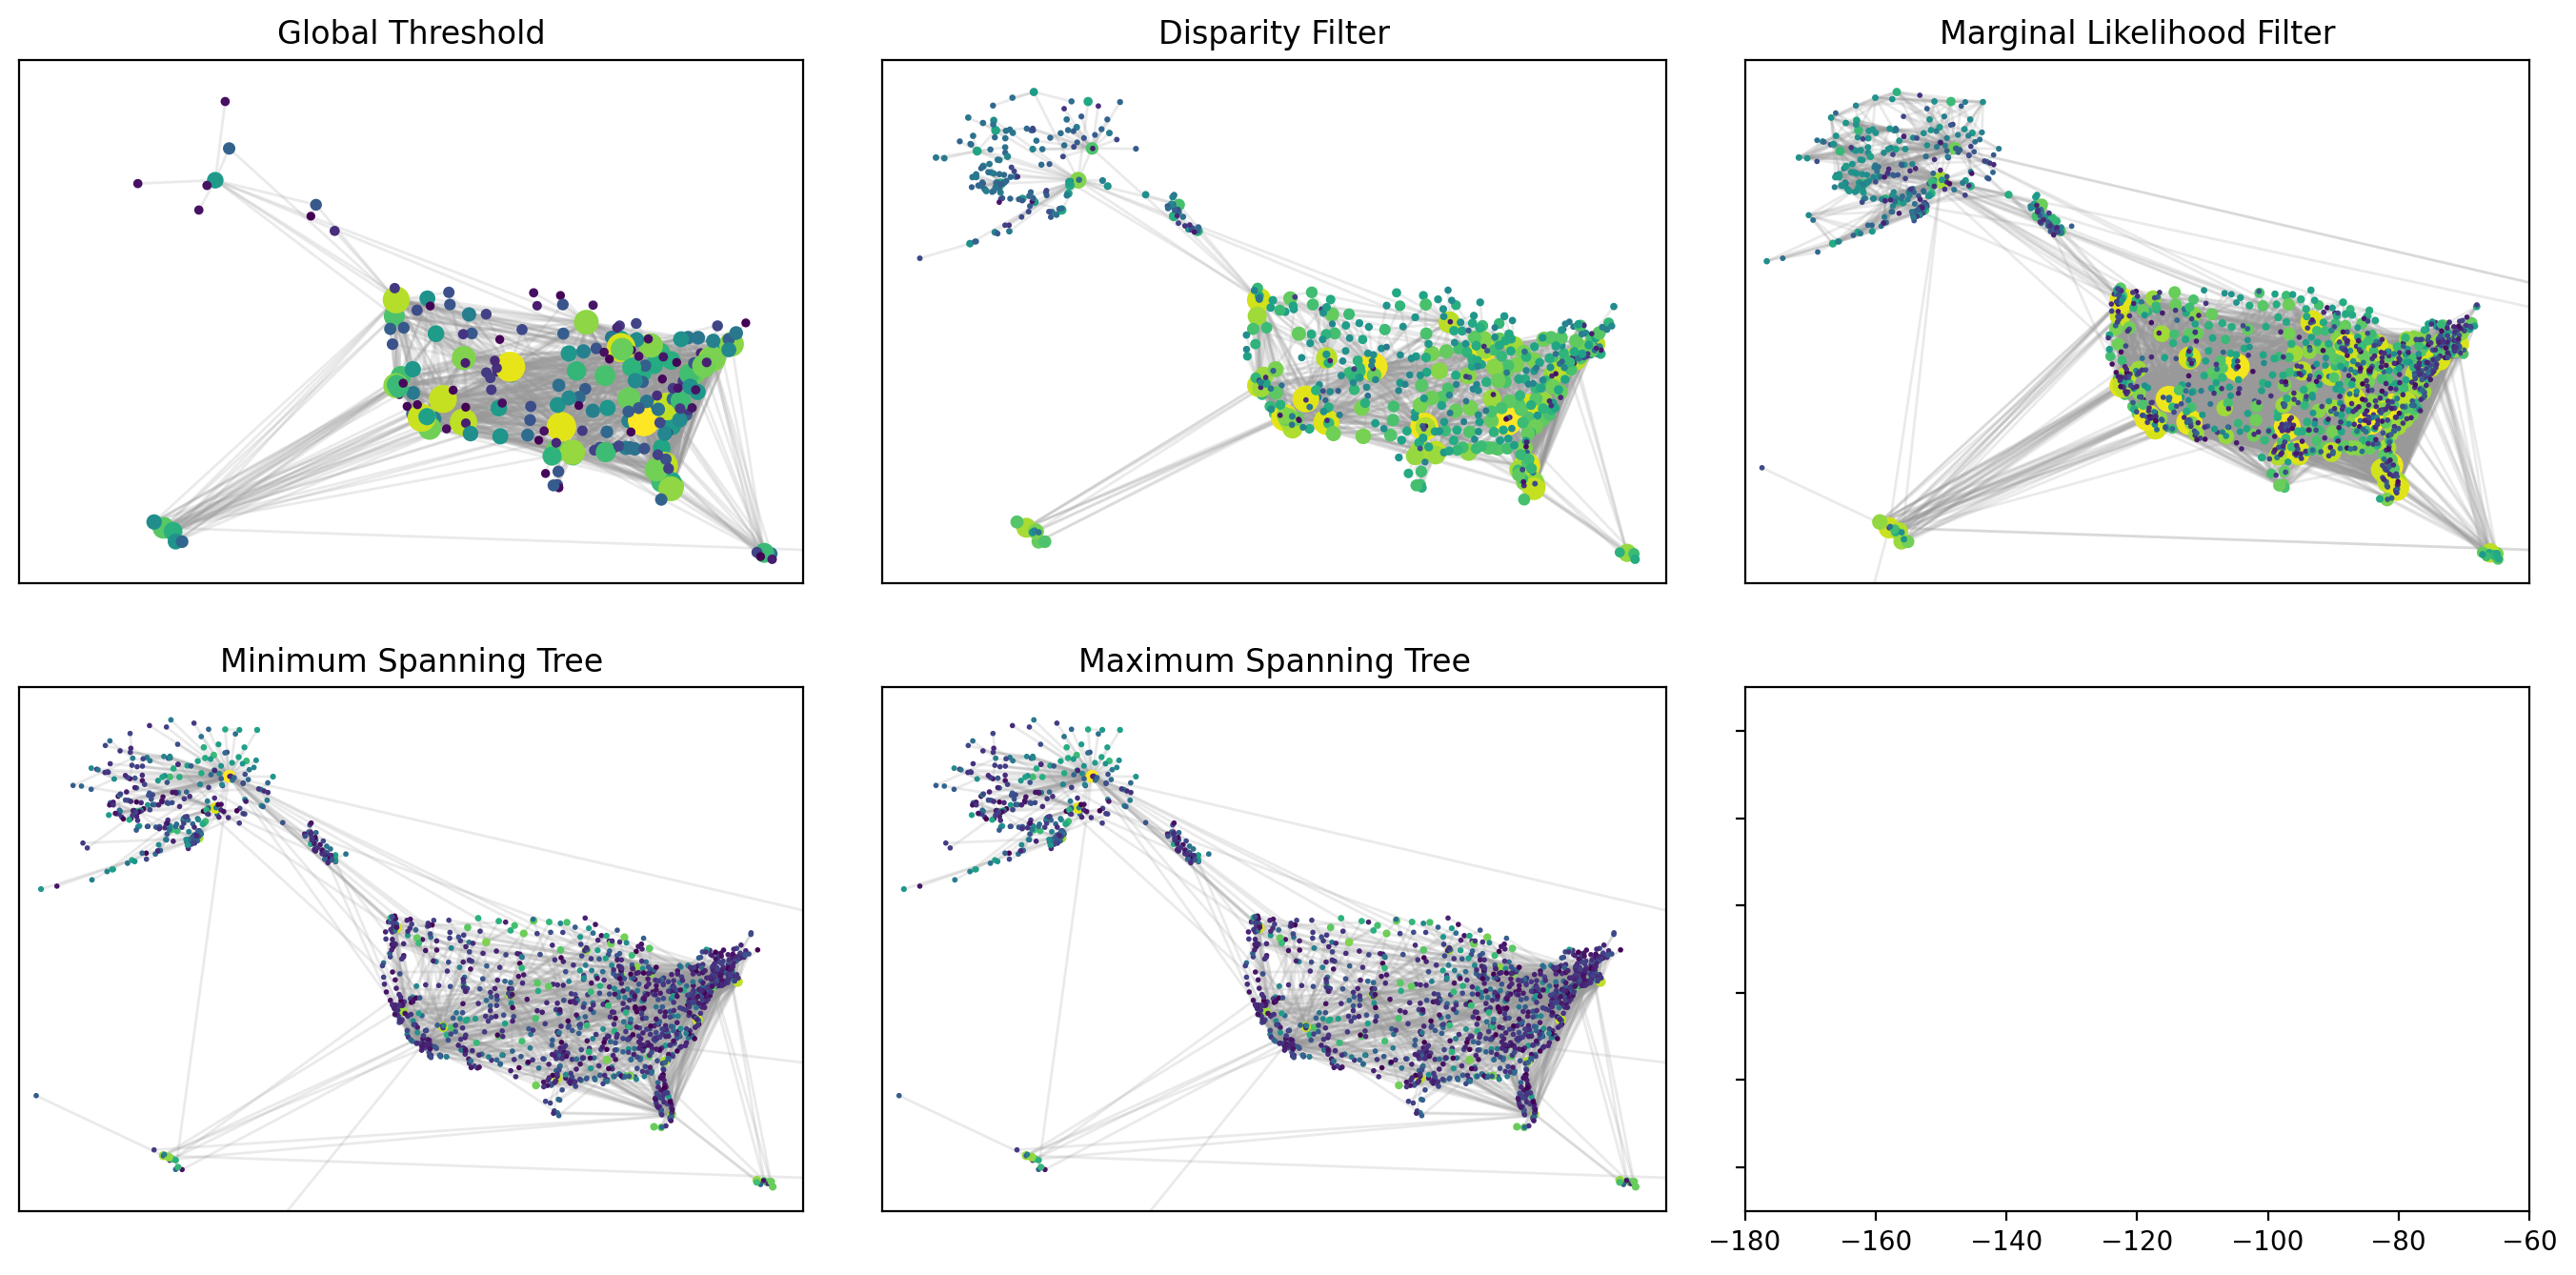

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(17,8), sharex=True, sharey=True, dpi=200)
plt.subplots_adjust(wspace=0.1)

func_names = ["Global Threshold", "Disparity Filter", "Marginal Likelihood Filter",
              'Minimum Spanning Tree', "Maximum Spanning Tree"]
backbone_functions = [threshold_graph, disparity_filter, marginal_likelihood_filter,
                      nx.maximum_spanning_tree, nx.minimum_spanning_tree, ]
parameters = [200000, 0.001, 0.000001, 'kruskal', 'kruskal']
sparsified_networks = []

for i, func in enumerate(backbone_functions):
    airport_network_sparsified = func(airport_network, parameters[i])
    sparsified_networks.append(airport_network_sparsified)
    
    node_strength = {node: sum(weight for _, _, weight in airport_network_sparsified.edges(node, data="weight"))
                     for node in airport_network_sparsified.nodes}
    node_sizes = np.array([2 + 0.02 * np.sqrt(node_strength[node]) for node in airport_network_sparsified.nodes])/2
    node_colors = [np.log10(node_strength[node]) for node in airport_network_sparsified.nodes]

    nx.draw_networkx_nodes(airport_network_sparsified, pos=pos, node_color=node_colors,
                           node_size=node_sizes, cmap=plt.cm.viridis, ax=axes.flat[i])
    
    nx.draw_networkx_edges(airport_network_sparsified, pos=pos, alpha=0.2, 
                           edge_color=".6", ax=axes.flat[i])

    axes.flat[i].set_title(func_names[i])
    axes.flat[i].set_xlim(-180, -60)
    axes.flat[i].set_ylim(15, 75)


plt.savefig('images/pngs/compare_filters.png', dpi=425, bbox_inches='tight')
plt.savefig('images/pdfs/compare_filters.pdf', dpi=425, bbox_inches='tight')
plt.show()

## How to evaluate sparsification techniques?

So far, we have extracted different backbones for the U.S. domestic flights from 2021 to 2022. How can we evaluate the quality of each backbone? First, what we mean by quality will depend on our interests. For example, if we just care about having a nice visualization, we could that the backbones extracted using Disparity Filter and Maximum Spanning Tree are better than the other two. If we care about having connectivity, we could assert that MST is the best one. There are different things we could use as an evaluation metric to compare different backbones of a single network.

We can separate metrics intro three groups, where we measure: topological properties, topological properties distributions, and dynamics. In this notebook, we will mainly focus on topological properties.

### Topological properties

The simplest way of evaluating a backbone is by comparing different topological properties. Here, we select _node fraction_, _edge fraction_, _weight fraction_, _average degree, _density_, and _reachability_.


#### (If there's time) Your Turn!

Implement a function that computes the topological properties mentioned above for a list of backbones, and create a nice visualization of it.

In [35]:
def topological_properties(graph, original_graph):
    """
    Compute topological properties of a graph compared to the original graph.

    Parameters:
        graph (networkx.Graph): The backbone graph to evaluate.
        original_graph (networkx.Graph): The original graph to compare against.

    Returns:
        dict: A dictionary containing the following metrics:
            - Node Fraction: Fraction of nodes retained in the backbone.
            - Edge Fraction: Fraction of edges retained in the backbone.
            - Weight Fraction: Fraction of total edge weight retained in the backbone.
            - Average Degree: Average degree of nodes in the backbone.
            - Density: Density of the backbone.
            - Reachability: Fraction of nodes in the largest connected component.
    """
    
    pass
    
#     return metrics

__________

In [36]:
def topological_properties(graphs, original_graph):
    """
    Compute topological properties for a list of graphs compared to the original graph.

    Parameters:
        graphs (list of networkx.Graph): List of backbone graphs to evaluate.
        original_graph (networkx.Graph): The original graph to compare against.

    Returns:
        list of dict: A list of dictionaries containing the following metrics for each graph:
            - Node Fraction: Fraction of nodes retained in the backbone.
            - Edge Fraction: Fraction of edges retained in the backbone.
            - Weight Fraction: Fraction of total edge weight retained in the backbone.
            - Average Degree: Average degree of nodes in the backbone.
            - Density: Density of the backbone.
            - Reachability: Fraction of nodes in the largest connected component.
    """
    metrics_list = []
    for graph in graphs:
        metrics = {}
        metrics["Node Fraction"] = graph.number_of_nodes() / original_graph.number_of_nodes()
        metrics["Edge Fraction"] = graph.number_of_edges() / original_graph.number_of_edges()
        total_weight_original = sum(weight for _, _, weight in original_graph.edges(data="weight", default=1))
        total_weight_backbone = sum(weight for _, _, weight in graph.edges(data="weight", default=1))
        metrics["Weight Fraction"] = total_weight_backbone / total_weight_original
        #metrics["Average Degree"] = np.mean([deg for _, deg in graph.degree()])
        metrics["Density"] = nx.density(graph)
        largest_cc = max(nx.connected_components(graph), key=len)
        metrics["Reachability"] = len(largest_cc) / graph.number_of_nodes()
        metrics_list.append(metrics)
    return metrics_list

In [37]:
def radar_chart(metrics_list, labels, title):
    """
    Create an improved radar chart to visualize multiple metrics across different backbones.

    Parameters:
        metrics_list (list of dict): List of dictionaries containing metrics for each backbone.
        labels (list of str): Labels for each backbone.
        title (str): Title of the radar chart.

    Returns:
        None
    """
    categories = list(metrics_list[0].keys())
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={"polar": True}, dpi=100)
    for metrics, label in zip(metrics_list, labels):
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, label=label, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], color="gray", size=8)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, y=1.1)
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=9)
#     sns.set_style("whitegrid")
#     plt.tight_layout()
    plt.show()

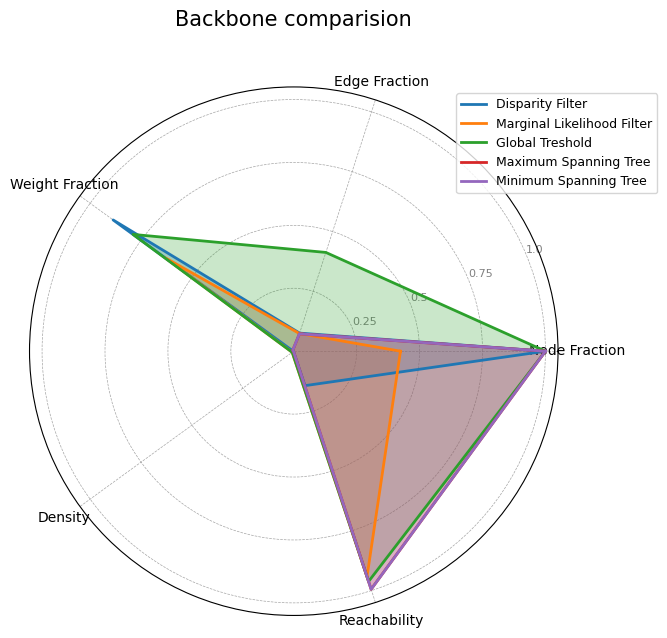

In [38]:
metrics_list = topological_properties(sparsified_networks, airport_network)
labels = ["Disparity Filter", "Marginal Likelihood Filter", "Global Treshold",
          "Maximum Spanning Tree", 'Minimum Spanning Tree']
radar_chart(metrics_list, labels, "Backbone comparision")

## Conclusion

Large and complex networks often present significant challenges. The sheer number of nodes and edges can make them difficult to analyze, computationally expensive to process, and hard to interpret visually. This is where network sparsification becomes a valuable tool. By simplifying networks and keeping only the most important connections, we can make our work much more efficient and focused, while still preserving the key information we need.

The main lesson here is that each method serves a specific purpose, and choosing the right one depends on your goal. Do you want a clearer visualization? Do you need to preserve connectivity? Or are you looking to make computations faster? Sparsification offers tools to meet these needs, and experimenting is an essential item in the network scientist toolkit in order to find the best approach.

We recommend consulting documentation for the [`netbone`](https://gitlab.liris.cnrs.fr/coregraphie/netbone) Python library, which implements all the techniques covered in this notebook, as well a many more state-of-the-art backbone extraction methods. Also, it offers a complete evaluation framework.

**Source:** Yassin, A., Haidar, A., Cherifi, H., Seba, H., & Togni, O. (2023). An evaluation tool for backbone extraction techniques in weighted complex networks. *Scientific Reports*, 13(1), 17000. https://www.nature.com/articles/s41598-023-42076-3

__________

## References and further resources:

1. Class Webpages
    - Github: https://github.com/network-science-data-and-models/cnet5052_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5052-spring26
2. Alvarez-Hamelin, J. I., Dall'Asta, L., Barrat, A., & Vespignani, A. (2005). k-core decomposition: A tool for the visualization of large scale networks. https://hal.science/hal-00004807v2/file/k-cores_AHDVB_v2.pdf
3. Bonanno, G., Caldarelli, G., Lillo, F., & Mantegna, R. N. (2003). Topology of correlation-based minimal spanning trees in real and model markets. *Physical Review E*, 68(4), 046130. https://doi.org/10.1103/PhysRevE.68.046130
4. Daqing, L., Kosmidis, K., Bunde, A., & Havlin, S. (2011). Dimension of spatially embedded networks. *Nature Physics*, 7(6), 481-484. https://www.nature.com/articles/nphys1932
5. Graham, R. L., & Hell, P. (1985). On the history of the minimum spanning tree problem. *Annals of the History of Computing*, 7(1), 43-57. http://doi.org/10.1109/MAHC.1985.10011
6. Radicchi, F., Ramasco, J. J., & Fortunato, S. (2011). Information filtering in complex weighted networks. *Physical Review E*, 83(4), 046101. http://doi.org/10.1103/PhysRevE.83.046101
7. Seidman, S. B. (1983). Network structure and minimum degree. *Social Networks*, 5(3), 269-287. http://doi.org/10.1016/0378-8733(83)90028-X
8. Serrano, M. Á., Boguná, M., & Vespignani, A. (2009). Extracting the multiscale backbone of complex weighted networks. *Proceedings of the National Academy of Sciences*, 106(16), 6483-6488. https://www.pnas.org/doi/10.1073/pnas.0808904106
9. Tumminello, M., Aste, T., Di Matteo, T., & Mantegna, R. N. (2005). A tool for filtering information in complex systems. *Proceedings of the National Academy of Sciences*, 102(30), 10421-10426. https://doi.org/10.1073/pnas.0500298102
10. Spielman, D. A., & Srivastava, N. (2011). Graph sparsification by effective resistances. *SIAM Journal on Computing*, 40(6), 1913–1926. https://doi.org/10.1137/080734029
11. Benczúr, A. A., & Karger, D. R. (2015). Randomized approximation schemes for cuts and flows in capacitated graphs. SIAM Journal on Computing, 44(2), 290–319. https://doi.org/10.1137/070705970
12. Hamann, M., Lindner, G., Meyerhenke, H., Staudt, C. L., & Wagner, D. (2016). Structure-preserving sparsification methods for social networks. *Social Network Analysis and Mining*, 6, 23. https://arxiv.org/abs/1601.00286
13. Dianati, N. (2016). Unwinding the hairball graph: Pruning algorithms for weighted complex networks. Physical Review E, 93(1), 012304. https://doi.org/10.1103/PhysRevE.93.012304
14. Mercier, A., Scarpino, S., & Moore, C. (2022). Effective resistance against pandemics: Mobility network sparsification for high-fidelity epidemic simulations. PLoS Computational Biology, 18(11). https://doi.org/10.1371/journal.pcbi.1010650
15. Neal, Z. (2014). The backbone of bipartite projections: Inferring relationships from co-authorship, co-sponsorship, co-attendance and other co-behaviors. Social Networks, 39, 84–97. https://doi.org/10.1016/j.socnet.2014.06.001
16. Simas, T., Correia, R.B., & Rocha, L.M.. The distance backbone of complex networks. *Journal of Complex Networks*, 9:cnab021, 2021. https://doi.org/10.1093/comnet/cnab021.
17. Yassin, A., Haidar, A., Cherifi, H., Seba, H., & Togni, O. (2023). An evaluation tool for backbone extraction techniques in weighted complex networks. *Scientific Reports*, 13(1), 17000. https://www.nature.com/articles/s41598-023-42076-3

## Part 2: From Removing Edges to Predicting Them

So far, we have treated the network as *over-specified*: a graph with more edges than are necessary to capture the structure we care about. Sparsification addresses this by identifying edges that are redundant, weak, or structurally unimportant, and removing them in a controlled way.

Link prediction asks a complementary question. Instead of assuming the network has too many edges, we now assume it has *too few*. The task shifts from deciding which edges can be removed to deciding which missing edges are most likely to exist, either because they were unobserved or because they may appear in the future.

Despite this change in perspective, the two problems are closely linked. In both cases, we assign scores to edges based on network structure. Sparsification removes edges with low importance, while link prediction elevates non-edges with high plausibility. Many of the same structural signals appear in both settings, including neighborhood overlap, similarity measures, and notions of redundancy and transitivity.

This symmetry is not accidental. Both sparsification and link prediction force us to confront the same underlying issue: edge sets are artifacts of measurement and modeling choices. By moving from removing edges to predicting them, we transition from questions of representation to questions of inference, while relying on a shared structural vocabulary.


## Introduction to link prediction in networks

In many real-world systems, networks are not static: new ties appear over time (friendships, collaborations, hyperlinks, trade relations), and sometimes ties disappear. Sometimes, the network was collected with errors present, or there is inherent stochasticity or noise in the link formation process. Our basic predictive task, then, is:

> Given a snapshot of a network at time $t$, which pairs of nodes are currently not connected but either likely will be at time $t + \Delta t$ or *should already be but are not through network noise*?

This formulation covers two closely related problems (Liben-Nowell and Kleinberg, 2007; Lü and Zhou, 2011):

* **Future link prediction**, where we treat the current graph as $G(t)$ and try to anticipate edges that will appear at a later time $t + \Delta t$ but are not yet present.
* **Missing link inference**, where we treat the observed network as a noisy or incomplete version of some latent "true" graph and try to infer edges that should exist but were not observed.

In both cases, the core task is to assign a score $s(i,j)$ to each *non-edge* $(i,j)$ and to rank these candidate pairs by how likely they are to be "real" edges under whatever mechanism we believe is shaping the network.

![](images/link_prediction.png)

### A wide range of application areas

* recommendation systems, where we represent users and items as a bipartite graph and predict which missing user-item edges are most likely to appear in the future;
* social and information networks, where we forecast new friendships, citations, or hyperlinks based on the current topology;
* biological networks, where we infer missing protein-protein interactions or regulatory links that are plausible given the observed interaction structure;
* knowledge graphs, where we attempt to fill in missing relationships between entities.

From a machine learning perspective, link prediction sits at the intersection of **supervised learning** and structured, graph-based modeling. On the one hand, we can treat each node pair $(i,j)$ as an example with a binary label (edge vs non-edge) and learn from features that summarize their structural context ([Liben-Nowell and Kleinberg, 2007](https://onlinelibrary.wiley.com/doi/full/10.1002/asi.20591)). On the other hand, many methods are **unsupervised** in the usual sense: they define scores $s(i,j)$ using purely structural heuristics (for example, common neighbors) or by fitting generative models of network formation (for example, stochastic block models or hierarchical random graphs; [Clauset, Moore, and Newman, 2008](https://www.nature.com/articles/nature06830)).


_______
#### In this chapter we will:
- formalize link prediction as a supervised learning and ranking problem on node pairs;
- construct a simple train/test split by hiding a subset of edges from a known graph;
- implement a set of classical neighborhood-based similarity scores:
    - common neighbors,
    - Jaccard coefficient,
    - Adamic-Adar index,
    - preferential attachment,
    - resource allocation index;
- evaluate these heuristics using ROC-AUC and precision at top-$k$;
- treat these scores as features in a simple logistic regression model;
- examine a case (a disassortative stochastic block model) where local heuristics perform poorly, motivating more expressive generative models;
- connect link prediction to recommendation systems, sparsification, and model-based approaches such as hierarchical random graphs.

Our goal is not to cover modern graph representation learning or graph neural networks, but to build intuition and strong, interpretable baselines using only `networkx` and standard scientific Python. These baselines are both practically useful and conceptually important: they clarify what kinds of structural information are already captured by simple heuristics, and they provide reference points against which more complex models must be justified.

In [154]:
import itertools
import random

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

# For reproducibility

SEED = 42
rng = np.random.default_rng(SEED)
random.seed(SEED)

### A toy network for link prediction

In practice, link prediction is often studied on longitudinal data: we observe the network at multiple time points $\{G(t_0), G(t_1), \dots\}$ and try to predict which non-edges at time $t_i$ become edges at time $t_{i+1}$. Here we approximate this temporal setting by synthetically hiding a subset of edges.

For clarity, we start with a single undirected, unweighted graph $G$ and treat it as if it were a snapshot at some time $t$. We will use a Barabási-Albert graph as a stylized model of a network with a broad, heavy-tailed degree distribution. This is not necessary for link prediction, but it gives us a simple example where degree heterogeneity matters and where neighborhood-based heuristics are non-trivial.

Recall that the BA model grows the network by repeatedly adding new nodes, each of which connects to $m$ existing nodes with probability proportional to their degree ("preferential attachment"). This produces hubs and a skewed degree distribution.

Number of nodes: 200
Number of edges: 591


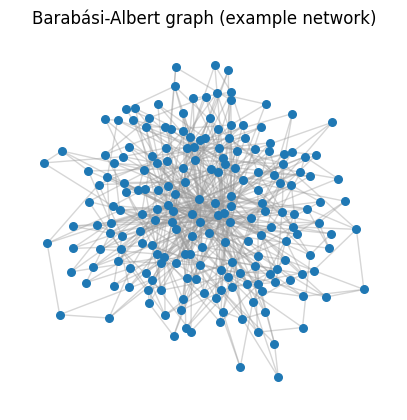

In [155]:
N = 200
m = 3

G_full = nx.barabasi_albert_graph(N, m, seed=SEED)

print(f"Number of nodes: {G_full.number_of_nodes()}")
print(f"Number of edges: {G_full.number_of_edges()}")

pos = nx.spring_layout(G_full, seed=SEED)


fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)
nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax)
nx.draw_networkx_edges(G_full, pos, alpha=0.4, edge_color='.6', ax=ax)
ax.set_axis_off()

ax.set_title("Barabási-Albert graph (example network)")

plt.show()

#### ...okay now what (your turn)

We're setting up a link prediction task using synthetic data. Where do we start?


In [41]:
pass

____________

### Constructing a train/test split by hiding edges

To turn link prediction into a supervised learning problem, we need examples of node pairs that *do* become edges and node pairs that *do not*. In truly temporal data we would use two snapshots, $G(t_0)$ and $G(t_1)$, and define positives as edges that appear between $t_0$ and $t_1$. In this chapter, however, we approximate this setting by **hiding** a random subset of edges from a single static graph.

The basic idea is:
1. Start from the original graph $G = (V, E)$.
2. Randomly select a fraction of existing edges to hold out as a **test set**, $E_{\text{test}} \subset E$.
3. Remove these edges from the graph to obtain a **training graph**, $ G_{\text{train}} = (V, E_{\text{train}})$ with $ E_{\text{train}} = E \setminus E_{\text{test}} $
4. Treat each $(i, j) \in E_{\text{test}}$ as a *positive* example for evaluation.
5. Sample an equal number of node pairs that are non-edges in the original graph as *negative* examples.

All link prediction scores in this chapter will be computed on $G_{\text{train}}$. 

**The evaluation task is then: using only $G_{\text{train}}$, assign higher scores to the hidden edges in $E_{\text{test}}$ than to the sampled non-edges.**

**Note:** One subtlety is connectivity. If we remove edges arbitrarily, we may disconnect $G_{\text{train}}$ in ways that make the task less realistic or break methods that assume a single connected component. To avoid this, our splitting function can optionally avoid removing bridges (aka edges whose removal would disconnect the graph). When `ensure_connected=True`, we only hide non-bridge edges, so that $G_{\text{train}}$ remains connected.


The helper function below wraps all of this into a single call:

- Input: an undirected simple graph `G`, a test fraction, and a random seed.
- Output:
  - `G_train`: the training graph with some edges removed,
  - `test_edges`: the list of hidden edges (positives),
  - `test_non_edges`: a sampled list of non-edges (negatives) of the same size.

We will reuse this function throughout the chapter to generate consistent train/test splits for different graphs and methods.


In [42]:
def train_test_split_graph(G, test_frac=0.2, seed=5, ensure_connected=True):
    """
    Create a train/test split of edges for link prediction.

    Parameters
    ----------
    G : nx.Graph
        Original undirected graph (assumed simple).
    test_frac : float
        Target fraction of edges to hide for testing (between 0 and 1).
    seed : int
        Random seed for reproducibility.
    ensure_connected : bool
        If True, avoid removing edges that would disconnect the training graph.
        If there are not enough non-bridge edges, fewer than test_frac * |E|
        edges will be removed.

    Returns
    -------
    G_train : nx.Graph
        Training graph with some edges removed.
    test_edges : list of (i, j)
        Edges that were removed and will be used as positive test examples.
    test_non_edges : list of (i, j)
        Node pairs that are not edges in the original graph, used as
        negative examples.
    """
    rng_local = np.random.default_rng(seed)

    # Work on a copy so we never mutate the original input graph
    G_train = G.copy()
    all_edges = list(G_train.edges())
    n_edges = len(all_edges)

    # Number of edges we will try to hide (may be fewer if we run out
    # of non-bridge edges when ensure_connected=True)
    n_test = int(test_frac * n_edges)

    # Randomize edge order so the choice of hidden edges is uniform-ish
    rng_local.shuffle(all_edges)
    test_edges = []

    if ensure_connected:
        # Remove edges one by one, skipping bridges to keep G_train connected
        for (i, j) in all_edges:
            if len(test_edges) >= n_test:
                break

            # Bridges change as we remove edges, so we recompute them each time
            # (fine for small/medium graphs; this is a teaching function)
            bridges = set(nx.bridges(G_train)) if nx.has_bridges(G_train) else set()

            # If this edge is currently a bridge, skip it to avoid disconnecting
            if (i, j) in bridges or (j, i) in bridges:
                continue

            # Otherwise, remove the edge and record it as a positive test example
            G_train.remove_edge(i, j)
            test_edges.append((i, j))
        # Note: if there are not enough non-bridge edges, test_edges may end up
        # shorter than n_test; we handle that naturally below.
    else:
        # Simple random edge hold-out: remove the first n_test shuffled edges
        test_edges = all_edges[:n_test]
        G_train.remove_edges_from(test_edges)

    # Sample negative examples (non-edges) from the *original* graph G.
    # Using G (not G_train) guarantees we never accidentally choose a hidden
    # positive edge as a "negative" example.
    non_edges = list(nx.non_edges(G))
    rng_local.shuffle(non_edges)

    # Take as many negatives as there are positives, so the test set is balanced
    test_non_edges = non_edges[: len(test_edges)]

    return G_train, test_edges, test_non_edges


In [156]:
G_train, test_edges, test_non_edges = train_test_split_graph(G_full, test_frac=0.2,
                                                     seed=SEED, ensure_connected=True)

print(f"Original graph edges: {G_full.number_of_edges()}")
print(f"Training graph edges: {G_train.number_of_edges()}")
print(f"Number of positive test edges: {len(test_edges)}")
print(f"Number of negative test non-edges: {len(test_non_edges)}")
print(f"Is G_train connected? {nx.is_connected(G_train)}")

Original graph edges: 591
Training graph edges: 473
Number of positive test edges: 118
Number of negative test non-edges: 118
Is G_train connected? True


In [157]:
non_G_plotting = nx.Graph()
non_G_plotting.add_nodes_from(G_full.nodes())
non_G_plotting.add_edges_from(test_non_edges)

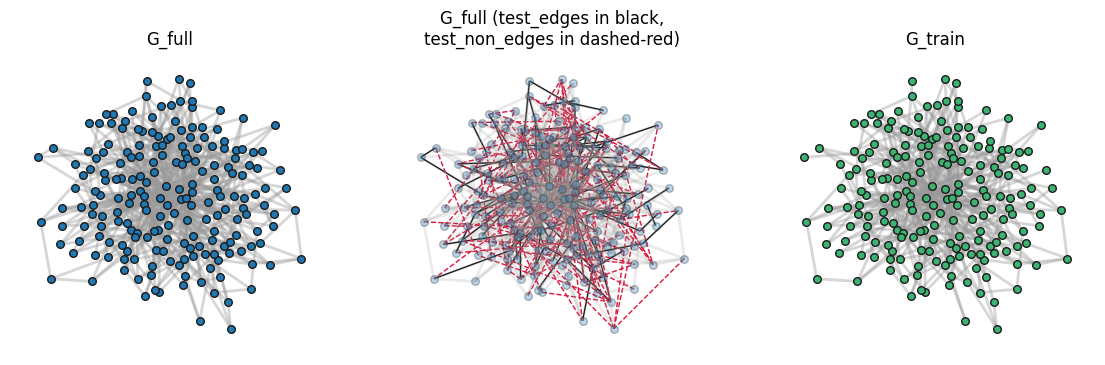

In [158]:
fig, ax = plt.subplots(1,3,figsize=(14,4),dpi=100)

nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax[0], edgecolors='.1')
nx.draw_networkx_edges(G_full, pos, alpha=0.4, edge_color='.6', ax=ax[0], width=2)
ax[0].set_axis_off()
ax[0].set_title("G_full")

nx.draw_networkx_edges(G_full, pos, edgelist=test_edges, edge_color='k', ax=ax[1], width=1)
nx.draw_networkx_edges(non_G_plotting, pos, edgelist=test_non_edges,
                       edge_color='crimson', ax=ax[1], width=1, style='--')
nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax[1], alpha=0.3, edgecolors='.1')
nx.draw_networkx_edges(G_full, pos, alpha=0.2, edge_color='.6', ax=ax[1], width=2)
ax[1].set_axis_off()
ax[1].set_title("G_full (test_edges in black,\ntest_non_edges in dashed-red)")


nx.draw_networkx_nodes(G_train, pos, node_size=30, node_color='mediumseagreen', edgecolors='.1', ax=ax[2])
nx.draw_networkx_edges(G_train, pos, alpha=0.4, edge_color='.6', ax=ax[2], width=2)
ax[2].set_axis_off()
ax[2].set_title("G_train")



plt.show()

### Other practical considerations in constructing link prediction datasets

Our simple setup—randomly hiding a fraction of edges and sampling an equal number of non-edges—captures the basic structure of a link prediction task, but real applications introduce several subtleties:

1. **Temporal vs random splits.**
   Here we pretend that $G_{\text{full}}$ is a snapshot at time $t$ and we randomly remove edges to simulate "future" links. In genuinely temporal data, we would instead:

   * take an earlier snapshot $G(t_0)$ as the training graph,
   * define positives as new edges that appear by $t_1 > t_0$ but were absent at $t_0$,
   * sample negatives from pairs that remain non-edges at $t_1$.
     Random removal is pedagogically useful but can overestimate performance compared to truly time-respecting splits.

2. **Class imbalance and negative sampling.**
   In a graph with $n$ nodes and $m$ edges, the number of non-edges is on the order of $n^2$, while the number of positives is only $m$. Future links are rare. For computational reasons, we typically *subsample negatives rather than consider all non-edges*, and we often construct balanced datasets (as we did above) for clarity.

3. **Candidate set restrictions.**
   Many methods implicitly assume that new edges tend to close triangles. A common evaluation variant restricts candidates to node pairs at distance two in $G_{\text{train}}$, i.e., pairs that already share at least one neighbor. This focuses attention on "plausible" links and avoids rewarding trivial behavior on pairs that are far apart.

4. **Transductive vs inductive prediction.**
   In this chapter we only predict links between nodes that already exist in $G_{\text{train}}$ (transductive). In some applications (for example, recommending items to a new user), we must predict edges incident to nodes that did not exist at training time (inductive), which typically requires node attributes or more flexible models.

These details matter whenever we compare methods across datasets or claim that one algorithm outperforms another (see, e.g., the survey by [Lü and Zhou, 2011](https://www.sciencedirect.com/science/article/pii/S037843711000991X)).
__________

## Extended note: Class imbalance in link prediction

A structural feature of link prediction problems is that they are **extremely imbalanced**. In a simple undirected graph with $n$ nodes, there are

$$
\binom{n}{2} = \frac{n(n-1)}{2}
$$

possible node pairs. Only $m$ of these pairs are observed edges; the rest are non-edges. In most real networks $m \ll \binom{n}{2}$, so the fraction of pairs that are connected is tiny.

For example, if $n = 10^5$ and $m = 10^6$, then:

* the number of possible pairs is on the order of $10^{10}$,
* the edge density $m / \binom{n}{2}$ is on the order of $10^{-4}$,
* for every positive (an actual or future edge) there are tens of thousands of negatives (pairs that never connect).

This class imbalance shapes both how we construct datasets and how we interpret evaluation metrics.



### Why we artificially balance positives and negatives

In the experiments below, we created balanced test sets by:

* hiding a subset of edges as positives (for example, $|E_{\text{test}}|$ edges), and
* sampling an equal number of non-edges as negatives.

This artificial balancing is useful for teaching and small-scale experiments:

1. It keeps the dataset size manageable: we do not need to score all $O(n^2)$ non-edges.
2. It avoids trivial baselines that achieve nearly perfect accuracy by predicting "no edge" almost everywhere.
3. It makes metrics like ROC-AUC and precision@$k$ easier to interpret numerically.

However, it also means that our reported numbers do not directly reflect performance on the full, highly imbalanced space of all candidate pairs.

### Why *accuracy* is misleading

Consider a classifier that predicts "no link" for every candidate pair: if we evaluate it on all pairs $(i,j)$, its accuracy is extremely high (close to 1), because almost all pairs are non-edges... but it is useless for link prediction, because it never finds any new edges.

Even on balanced test sets, accuracy can be a weak indicator of ranking quality. This is why link prediction work typically reports ranking metrics (ROC-AUC, precision@$k$, average precision) rather than raw accuracy. More on this sooon!

Because we rarely evaluate on all non-edges, we must decide which *negatives to sample*. Different choices answer different questions:

* Uniform negative sampling asks whether the method can separate future edges from "typical" non-edges.
* Distance-restricted sampling focuses on deciding which open triads will close.
* Popularity- or exposure-aware sampling is common in recommendation systems, where not all non-edges are equally "negative".

The final numerical value of ROC-AUC or precision@$k$ should always be interpreted relative to how the negative examples were constructed.
_____________

## Let's predict some missing links!
... okay, how?

### Classical neighborhood-based link prediction scores

A large body of work on link prediction starts from a simple, intuitive idea:

> Two nodes are more likely to form a link if they have many neighbors in common or if they are embedded in similar local neighborhoods.

In social networks, this is the notion of *triadic closure* (i.e., the "friends of my friends are likely to become my friends.") In other domains, it corresponds to functional similarity (two neurons that interact with many of the same partners may be part of the same cluster) or topical relatedness (two web pages that are connected by many others may cover similar content).

For an undirected graph, let $\Gamma(i)$ denote the set of neighbors of node $i$, and let $k_i = |\Gamma(i)|$ be its degree. The simplest neighborhood-based link prediction scores are functions of overlaps between $\Gamma(i)$ and $\Gamma(j)$ and the degrees of $i$, $j$, and their common neighbors. **THERE ARE SO MANY LINK PREDICTION ALGORITHMS,** but let's focus on a couple canonical ones here.



1. **Common neighbors (CN)**
    The most direct measure simply counts how many neighbors $i$ and $j$ share:

    $$
    s_{\text{CN}}(i, j) = |\Gamma(i) \cap \Gamma(j)|
    $$
    
    This implements the pure triadic-closure intuition: the more common neighbors two nodes have, the more opportunities there have been for a link to form between them. In early empirical work on social and information networks, Liben-Nowell and Kleinberg (2007) found that common neighbors alone can already perform surprisingly well.



2. **Jaccard coefficient**
    Common neighbors can be biased toward high-degree nodes: two hubs may share many neighbors simply because they each have many neighbors. The **Jaccard coefficient** normalizes by the size of the union:

    $$
    s_{\text{Jaccard}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{|\Gamma(i) \cup \Gamma(j)|}
    $$
    
    This is identical to the Jaccard similarity from information retrieval, applied to neighbor sets. It assigns a high score only when the shared neighbors form a large *fraction* of the nodes' combined neighborhoods, not just a large absolute count.




3. **Adamic-Adar index (AA)**
   The **Adamic-Adar index** (Adamic and Adar, 2003) refines common neighbors by downweighting common neighbors that are themselves very high-degree hubs:
   $$
   s_{\text{AA}}(i, j)
   = \sum_{l \in \Gamma(i) \cap \Gamma(j)} \frac{1}{\log k_l}
   $$
   The idea is that a common neighbor $l$ that is connected to *everyone* carries less specific information about similarity between $i$ and $j$ than a rare, low-degree neighbor. The logarithm in the denominator means that the penalty grows slowly with degree: very large degrees are heavily discounted, but modest differences among low-degree nodes still matter.




4. **Preferential attachment (PA)**
    The **preferential attachment** score uses only the degrees of $i$ and $j$:
    
    $$
    s_{\text{PA}}(i, j) = k_i,k_j
    $$
    
    This is motivated by preferential-attachment network models, in which new nodes attach to existing nodes with probability proportional to degree (Albert and Barabási, 2002). In such models, high-degree nodes tend to gain new neighbors more quickly, and pairs of hubs are especially likely to connect. Unlike the previous scores, PA does *not* look at common neighbors at all; it purely encodes the rich-getting-richer effect.




5. **Resource allocation index (RA)**
    The **resource allocation** index (Zhou, Lü, and Zhang, 2009) is similar in spirit to Adamic-Adar but uses a $1/k_l$ penalty instead of $1/\log k_l$:

    $$
    s_{\text{RA}}(i, j)
    = \sum_{l \in \Gamma(i) \cap \Gamma(j)} \frac{1}{k_l}
    $$
    
    This can be interpreted as a simple diffusion or resource-sharing process: imagine each common neighbor $l$ has one unit of "resource" and distributes it equally among its neighbors. The amount of resource that flows from $i$ to $j$ via $l$ is then $1/k_l$. Summing over all common neighbors measures how much resource $i$ could send to $j$ through paths of length two. Compared to Adamic-Adar, the $1/k_l$ penalty is stronger for high-degree nodes, so RA tends to emphasize rare, low-degree common neighbors even more.




All five scores are **local**: they depend only on the immediate neighborhoods of $i$ and $j$, and they assign higher scores to node pairs that are structurally similar in a first-order sense. They are symmetric in $i$ and $j$, and they can be computed for any non-edge $(i,j)$ without fitting a global model.

Despite their simplicity, these scores serve as strong, interpretable baselines in many applications, and they often perform competitively with more complex methods on social and information networks (Liben-Nowell and Kleinberg, 2007; Adamic and Adar, 2003; Lü and Zhou, 2011; Zhou, Lü, and Zhang, 2009). In the next section, we will implement each of them in `networkx` and compare their performance on synthetic and empirical graphs.

### Your turn!

We need functions for five link prediction algorithms:

```
1. common_neighbors_score
2. jaccard_score
3. adamic_adar_score
4. preferential_attachment_score
5. resource_allocation_score
```


In [ ]:
def common_neighbors_score(G, i, j):
    """
    Compute the common-neighbors score between nodes i and j.

    s_CN(i, j) = |Γ(i) ∩ Γ(j)|

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Common-neighbors score between i and j.
    """
    # TODO:
    # 1. Get the neighbor sets of i and j.
    # 2. Compute the size of their intersection.
    # 3. Return that value as a float.


In [47]:
def jaccard_score(G, i, j):
    """
    Compute the Jaccard coefficient between nodes i and j.

    s_Jaccard(i, j) = |Γ(i) ∩ Γ(j)| / |Γ(i) ∪ Γ(j)|

    If both nodes have no neighbors (empty union), define the score to be 0.0.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Jaccard similarity between the neighbor sets of i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) as Python sets.
    # 2. Compute the intersection and union of these sets.
    # 3. If the union is empty, return 0.0.
    # 4. Otherwise, return |intersection| / |union| as a float.
    
    pass

In [48]:
def adamic_adar_score(G, i, j):
    """
    Compute the Adamic-Adar index between nodes i and j.

    s_AA(i, j) = sum_{w in Γ(i) ∩ Γ(j)} 1 / log(k_w)

    where k_w is the degree of the common neighbor w. You may skip or
    ignore terms where k_w <= 1 to avoid division by zero.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Adamic-Adar score between i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) and compute their intersection (common neighbors).
    # 2. For each common neighbor w:
    #       - Compute its degree k_w.
    #       - Add 1 / log(k_w) to a running sum (when k_w > 1).
    # 3. Return the final sum as a float.
    
    pass

In [2]:
def preferential_attachment_score(G, i, j):
    """
    Compute the preferential-attachment score between nodes i and j.

    s_PA(i, j) = k_u * k_v

    where k_u and k_v are the degrees of i and j.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Preferential-attachment score between i and j.
    """
    # TODO:
    # 1. Get the degrees of i and j from G.
    # 2. Return their product as a float.
    
    i_deg = G.degree(i)
    j_deg = G.degree(j)

    S = i_deg * j_deg

    return float(S)

In [50]:
def resource_allocation_score(G, i, j):
    """
    Compute the resource allocation index between nodes i and j.

    s_RA(i, j) = sum_{w in Γ(i) ∩ Γ(j)} 1 / k_w

    where k_w is the degree of the common neighbor w.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Resource-allocation score between i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) and compute their intersection (common neighbors).
    # 2. For each common neighbor w:
    #       - Compute its degree k_w.
    #       - Add 1 / k_w to a running sum (when k_w > 0).
    # 3. Return the final sum as a float.
    
    pass

In [51]:
pass

Don't look below!

________

In [52]:
def common_neighbors_score(G, i, j):
    """
    Compute the common-neighbors score between nodes i and j.

    s_CN(i, j) = |Γ(i) ∩ Γ(j)|,

    where Γ(i) is the set of neighbors of i.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Number of common neighbors between i and j.
    """
    # Neighbor sets of each node
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))

    # Intersection of neighbor sets
    common = neighbors_i & neighbors_j

    return float(len(common))


def jaccard_score(G, i, j):
    """
    Compute the Jaccard coefficient between nodes i and j.

    s_Jaccard(i, j) = |Γ(i) ∩ Γ(j)| / |Γ(i) ∪ Γ(j)|.

    If both nodes have no neighbors (empty union), the score is defined as 0.0.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Jaccard similarity between the neighbor sets of i and j.
    """
    # Neighbor sets of each node
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))

    # Intersection and union of neighbor sets
    intersection = neighbors_i & neighbors_j
    union = neighbors_i | neighbors_j

    # If both nodes are isolated, define similarity to be 0
    if not union:
        return 0.0

    return len(intersection) / len(union)


def adamic_adar_score(G, i, j):
    """
    Compute the Adamic-Adar index between nodes i and j.

    s_AA(i, j) = sum_{l in Γ(i) ∩ Γ(j)} 1 / log(k_l),

    where k_l is the degree of the common neighbor l.
    Terms with k_l <= 1 are skipped to avoid log(1) = 0 and log(0) issues.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Adamic-Adar score between i and j.
    """
    # Neighbor sets and common neighbors
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))
    common_neighbors = neighbors_i & neighbors_j

    score = 0.0

    # Accumulate 1 / log(k_l) across common neighbors
    for ell in common_neighbors:
        k_ell = G.degree[ell]
        # Skip degree 0 or 1 to avoid log(0) or division by zero
        if k_ell > 1:
            score += 1.0 / np.log(k_ell)

    return score


def preferential_attachment_score(G, i, j):
    """
    Compute the preferential-attachment score between nodes i and j.

    s_PA(i, j) = k_i * k_j,

    where k_i and k_j are the degrees of i and j.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Preferential-attachment score between i and j.
    """
    k_i = G.degree[i]
    k_j = G.degree[j]

    return float(k_i * k_j)


def resource_allocation_score(G, i, j):
    """
    Compute the resource allocation (RA) index between nodes i and j.

    s_RA(i, j) = sum_{l in Γ(i) ∩ Γ(j)} 1 / k_l,

    where k_l is the degree of the common neighbor l.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Resource-allocation score between i and j.
    """
    # Neighbor sets and common neighbors
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))
    common_neighbors = neighbors_i & neighbors_j

    score = 0.0

    # Accumulate 1 / k_l across common neighbors
    for ell in common_neighbors:
        k_ell = G.degree[ell]
        if k_ell > 0:
            score += 1.0 / k_ell

    return score


_______

#### What do these scores even look like?
Let's start by looking at the scores for the postitive edges, starting with Jaccard...

In [159]:
pos_scores_jac = [jaccard_score(G_train, i, j) for (i, j) in test_edges]

In [163]:
neg_scores_jac = [jaccard_score(G_train, i, j) for (i, j) in test_non_edges]

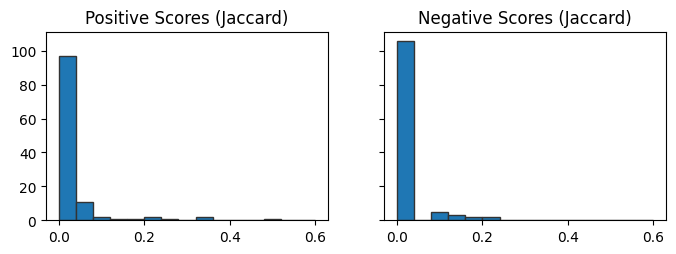

In [164]:
fig, ax = plt.subplots(1,2,figsize=(8,2.5),dpi=100,sharex=True,sharey=True)

ax[0].hist(pos_scores_jac,bins=np.linspace(0,0.6,16),ec='.2')
ax[1].hist(neg_scores_jac,bins=np.linspace(0,0.6,16),ec='.2')

ax[0].set_title('Positive Scores (Jaccard)')
ax[1].set_title('Negative Scores (Jaccard)')

plt.show()

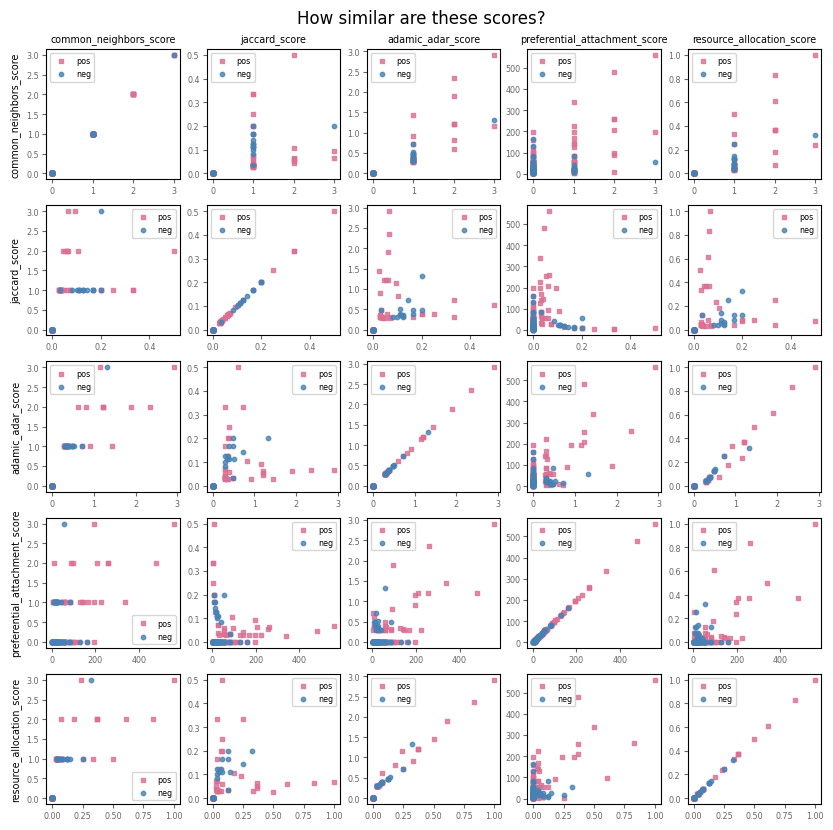

In [165]:
fig, ax = plt.subplots(5,5,figsize=(10,10),dpi=100)

labels = ['common_neighbors_score', 'jaccard_score', 'adamic_adar_score',
          'preferential_attachment_score', 'resource_allocation_score']
for i1, func1 in enumerate([common_neighbors_score, jaccard_score, adamic_adar_score,
                           preferential_attachment_score, resource_allocation_score]):
    
    pos_scores1 = [func1(G_train, i, j) for (i, j) in test_edges]
    neg_scores1 = [func1(G_train, i, j) for (i, j) in test_non_edges]

    for i2, func2 in enumerate([common_neighbors_score, jaccard_score, adamic_adar_score,
                               preferential_attachment_score, resource_allocation_score]):

        pos_scores2 = [func2(G_train, i, j) for (i, j) in test_edges]
        neg_scores2 = [func2(G_train, i, j) for (i, j) in test_non_edges]
        
        
        ax[i1,i2].scatter(pos_scores1, pos_scores2, s=10, marker='s',
                          c='palevioletred', label='pos', alpha=0.8)
        ax[i1,i2].scatter(neg_scores1, neg_scores2, s=10, marker='o',
                          c='steelblue', label='neg', alpha=0.8)
        
        if i1==0:
            ax[i1,i2].set_title(labels[i2],fontsize='x-small')

        if i2==0:
            ax[i1,i2].set_ylabel(labels[i1],fontsize='x-small')
            
        ax[i1,i2].tick_params(which='both', length=3, pad=2, labelsize='xx-small',
                              labelcolor='.4', color='.4')
        ax[i1,i2].legend(fontsize='xx-small')


plt.suptitle('How similar are these scores?', y=0.92)

plt.show()

### Evaluating a scoring function

Once we define a link-prediction score $s(i, j)$, we need a way to quantify how well it separates true future edges from non-edges. Given a training graph $G_{\text{train}}$, a set of hidden **positive** edges (the test edges), and a set of sampled **negative** pairs (non-edges), we can:

1. compute a score for each positive and negative example using our chosen function `score_fn(G, i, j)`,
2. build a label vector with 1 for positives and 0 for negatives,
3. compare the resulting scores and labels using the ROC-AUC metric.

The helper function below wraps this pattern: it takes a training graph, lists of positive and negative pairs, and a scoring function, and returns the labels, the scores, and the ROC-AUC value (optionally printing it as well). We will reuse this for all of the neighborhood-based scores in this chapter.



#### Evaluation Technique: ROC-AUC 

Given a score function $s(i, j)$, we can evaluate it on our labeled examples:

* For each positive test edge $(i, j) \in E_{\text{test}}$, compute its score.
* For each negative test pair $(i, j) \in \mathcal{N}_{\text{test}}$ (sampled non-edges), compute its score.

Ideally, the scores for positive examples are stochastically larger than those for negative examples.

One standard metric is the area under the receiver-operating characteristic curve (ROC-AUC). The ROC curve traces the trade-off between true positive rate and false positive rate as we vary the threshold on $s(i, j)$. The AUC has a useful interpretation:

> The AUC is the probability that a randomly chosen positive example receives a higher score than a randomly chosen negative example.

An AUC of $0.5$ corresponds to random guessing; an AUC of $1.0$ is perfect ranking.

__________

In [166]:
def evaluate_score_function(G_train, test_edges, test_non_edges, score_fn, verbose=True):
    """
    Evaluate a link-prediction scoring function using ROC-AUC.

    Parameters
    ----------
    G_train : networkx.Graph
        Training graph used to compute scores.
    test_edges : list of (i, j)
        Positive examples (edges that were removed from the original graph).
    test_non_edges : list of (i, j)
        Negative examples (node pairs that are non-edges in the original graph).
    score_fn : callable
        Function of the form score_fn(G, i, j) -> float.
    verbose : bool, optional
        If True, print the AUC value.

    Returns
    -------
    y_true : numpy.ndarray
        True labels (1 for positive edges, 0 for non-edges).
    y_scores : numpy.ndarray
        Scores assigned by score_fn to each example.
    auc : float
        ROC-AUC value.
    """
    # Scores for positive examples
    pos_scores = [score_fn(G_train, i, j) for (i, j) in test_edges]

    # Scores for negative examples
    neg_scores = [score_fn(G_train, i, j) for (i, j) in test_non_edges]

    # True labels: 1 for positives, 0 for negatives
    y_true = np.array([1] * len(pos_scores) + [0] * len(neg_scores))

    # Concatenate scores in the same order as labels
    y_scores = np.array(pos_scores + neg_scores)

    # Compute ROC-AUC
    auc = roc_auc_score(y_true, y_scores)

    if verbose:
        print(f"AUC = {auc:.3f}")

    return y_true, y_scores, auc


In [167]:
print("BA graph: Common neighbors:")
y_cn, scores_cn, auc_cn = evaluate_score_function(
    G_train, test_edges, test_non_edges, common_neighbors_score
)
print()
print("BA graph: Jaccard:")
y_jac, scores_jac, auc_jac = evaluate_score_function(
    G_train, test_edges, test_non_edges, jaccard_score
)

print()
print("BA graph: Adamic-Adar:")
y_aa, scores_aa, auc_aa = evaluate_score_function(
    G_train, test_edges, test_non_edges, adamic_adar_score
)

print()
print("BA graph: Preferential attachment:")
y_pa, scores_pa, auc_pa = evaluate_score_function(
    G_train, test_edges, test_non_edges, preferential_attachment_score
)

print()
print("BA graph: Resource allocation:")
y_ra, scores_ra, auc_ra = evaluate_score_function(
    G_train, test_edges, test_non_edges, resource_allocation_score
)


BA graph: Common neighbors:
AUC = 0.596

BA graph: Jaccard:
AUC = 0.585

BA graph: Adamic-Adar:
AUC = 0.592

BA graph: Preferential attachment:
AUC = 0.673

BA graph: Resource allocation:
AUC = 0.592


### Visualizing performance: ROC curves

Numerical AUC values are compact but opaque. It is often helpful to visualize the ROC curves for several methods on the same plot. This can reveal, for example, that two methods have similar AUC but behave differently at low false positive rates.

In settings like recommendation, we often care most about the left part of the ROC curve: how many true positives we can recover before we start incurring many false positives.


In [168]:
score_dict = {
    "Common neighbors": scores_cn,
    "Jaccard": scores_jac,
    "Adamic-Adar": scores_aa,
    "Preferential attachment": scores_pa,
    "Resource allocation": scores_ra,
}

In [169]:
y_true = y_cn.copy()

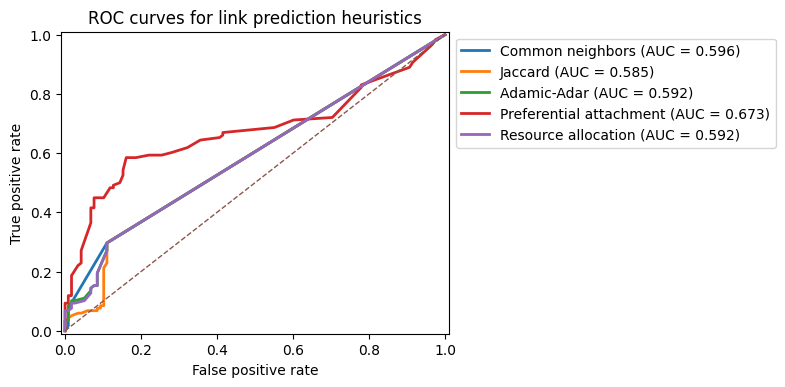

In [170]:
fig, ax = plt.subplots(1,1,figsize=(5, 4), dpi=100)

for name, scores in score_dict.items():
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", lw=2)

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves for link prediction heuristics")
ax.legend(bbox_to_anchor=[1.0,1.0],loc=2)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

__________
### Other structural link prediction scores

The heuristics above are part of a larger family of structurally defined similarity measures (Liben-Nowell and Kleinberg, 2007; Lü and Zhou, 2011), including:

* **Salton index (cosine similarity):**

    $$
    s_{\text{Salton}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\sqrt{k_i,k_j}}
    $$

* **Sørensen index:**

    $$
    s_{\text{Sørensen}}(i, j)
    = \frac{2,|\Gamma(i) \cap \Gamma(j)|}{k_i + k_j}
    $$

* **Hub-promoted and hub-depressed indices:**

    $$
    s_{\text{HPI}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\min{k_i, k_j}} ,
    \qquad
    s_{\text{HDI}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\max{k_i, k_j}}
    $$

Most of these differ only in how they normalize the common-neighbors count. Empirically, several of them achieve similar performance on social and information networks, and Common Neighbors, Jaccard, Adamic-Adar, and Resource Allocation often serve as representative baselines.


### Global similarity measures

The heuristics above depend only on the immediate neighborhoods of $i$ and $j$. One can also define **global** similarity measures that take into account paths of all lengths in the network. A classical example is the Katz index (Katz, 1953). Let $A$ be the adjacency matrix of $G$. For nodes $i$ and $j$, the Katz similarity is

$$
s_{\text{Katz}}(i, j)
= \sum_{l = 1}^{\infty} \beta^l \big[A^l\big]*{ij}
$$

where $\beta > 0$ is a decay parameter and $\big[A^l\big]*{ij}$ counts the number of walks of length $l$ from $i$ to $j$. Short walks contribute more than long walks, and all walks are downweighted by $\beta^l$. In practice one truncates this series at some maximum length or uses matrix methods to approximate it.

Random-walk-based scores, such as those derived from personalized PageRank or commute times, follow a similar spirit: they use properties of random walks on the graph to quantify how easily information can flow between two nodes. These global measures are more computationally demanding than local heuristics but can capture long-range structural information that local measures miss.
__________

## Ranking quality and precision at top-$k$

In many applications, we are not forced to classify all candidate pairs. Instead, we only act on the highest-scoring predictions, such as:

* recommending the top 10 new friends to each user,
* suggesting the top 50 potential collaboration links,
* prioritizing the top 100 candidate interactions for experimental validation.

In these scenarios, **precision at top-$k$** is often more meaningful than AUC. For a given $k$:

1. Sort all candidate pairs by their scores in descending order.
2. Take the top $k$ pairs.
3. Compute... $ \text{Precision@}k = \frac{\text{number of true edges among the top } k \text{ pairs}}{k} $

High precision at small $k$ indicates that the method is very good at identifying the most promising candidates.

In [173]:
def precision_at_k(y_true, y_scores, k):
    """
    Compute precision at top-k.

    Parameters
    ----------
    y_true : array-like
        True labels (1 for positive, 0 for negative).
    y_scores : array-like
        Scores for each example (higher means more likely positive).
    k : int
        Number of top predictions to consider.

    Returns
    -------
    float
        Fraction of the top-k scored examples that are actually positive.
    """
    if k <= 0:
        raise ValueError("k must be positive")

    # Do not ask for more than we have
    k = min(k, len(y_true))

    # Indices of examples sorted by score in descending order
    idx_sorted = np.argsort(-y_scores)

    # Take the top-k indices and compute the fraction that are positive
    topk_idx = idx_sorted[:k]

    return y_true[topk_idx].sum() / k

In [174]:
ks = [5, 10, 20, 50]

methods = {
    "Common neighbors": (y_cn, scores_cn),
    "Jaccard": (y_jac, scores_jac),
    "Adamic-Adar": (y_aa, scores_aa),
    "Preferential attachment": (y_pa, scores_pa),
    "Resource allocation": (y_ra, scores_ra),
}

for name, (y, scores) in methods.items():
    print(f"\n{name}:")
    for k in ks:
        p_at_k = precision_at_k(y, scores, k)
        print(f"  Precision@{k:2d} = {p_at_k:.3f}")



Common neighbors:
  Precision@ 5 = 0.800
  Precision@10 = 0.900
  Precision@20 = 0.950
  Precision@50 = 0.700

Jaccard:
  Precision@ 5 = 1.000
  Precision@10 = 0.600
  Precision@20 = 0.450
  Precision@50 = 0.700

Adamic-Adar:
  Precision@ 5 = 0.800
  Precision@10 = 0.900
  Precision@20 = 0.700
  Precision@50 = 0.700

Preferential attachment:
  Precision@ 5 = 1.000
  Precision@10 = 1.000
  Precision@20 = 0.900
  Precision@50 = 0.840

Resource allocation:
  Precision@ 5 = 1.000
  Precision@10 = 0.800
  Precision@20 = 0.650
  Precision@50 = 0.700


### Even more ways to measuring performance...

- **Accuracy**  --- Fraction of correct predictions.  

    $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}
    $$

- **Precision**  --- Fraction of true positive predictions among all positive predictions.  

    $$
    \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
    $$

- **Recall** --- Fraction of true positives identified among all actual positives (also called sensitivity).  
        
    $$
    \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
    $$

- **F1-Score**  --- Harmonic mean of Precision and Recall, balancing the two metrics.  

    $$
    F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
    $$

- **AUC-ROC** (Area Under the Receiver Operating Characteristic Curve) --- Evaluates a classifier's ability to discriminate between classes. It measures the area under the curve plotted between True Positive Rate (TPR) and False Positive Rate (FPR) at different thresholds:  

    $$
    \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
    $$

- **AUC-PR** (Area Under the Precision-Recall Curve) --- 
    Evaluates the trade-off between Precision and Recall across thresholds, useful for imbalanced datasets.


____________
### ...and even *more* (based on ranking)
Goal: evaluate the quality of *rankings* generated by the algorithm, how well the algorithm ranks true edges against false ones. MRR (mean reciprocal rank), Hit Rate, Kendall's Tau, MAP (Mean Average Precision)

**Mean Reciprocal Rank (MRR)**
Measures ranking quality for link prediction tasks, focusing on how highly a **true positive** is ranked:  

$$
\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}
$$

- $ Q $: Set of queries (node pairs).
- $ \text{rank}_i $: Position of the first relevant link for the $ i $-th query.


**Hit Rate**
Measures the fraction of queries where at least **one correct link prediction appears** in the top $ k $: ( e.g. the share of users for which at least one relevant item is present in the top k.)

$$
\text{Hit Rate} = \frac{\text{Number of queries with a relevant result in top-}k}{|Q|}
$$


**Kendall's Tau**
Measures the similarity between two rankings. It is a correlation measure based on the number of concordant and discordant pairs:  

$$
\tau = \frac{C - D}{\frac{1}{2}n(n-1)}
$$

- $ C $: Number of concordant pairs.
- $ D $: Number of discordant pairs.
- $ n $: Total number of ranked pairs.


**MAP (Mean Average Precision)**
Evaluates ranking by averaging precision at each relevant item in the ranking list for all queries: (average of the precisions calculated at the ranks where the **true positive links appear** in the ranked list.)

$$
\text{MAP} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \text{AP}_i, \quad \text{AP}_i = \frac{1}{m_i} \sum_{k=1}^{m_i} P(k)
$$

- $m_i $: Number of relevant items for the $ i $-th query.
- $ P(k) $: Precision at rank $ k $.
___________

-------

## Restricting candidate pairs to distance two

So far we have sampled negative examples uniformly from all non-edges. In very sparse graphs, many of these pairs are far apart and extremely unlikely to form edges. A different evaluation protocol, common in link prediction experiments, is to restrict attention to node pairs at distance $d=2$ in $G_{\text{train}}$.

A pair $(i, j)$ is at distance two if $i$ and $j$ are not directly connected but share at least one neighbor. Restricting candidates to distance-two pairs focuses the task on deciding which open triads will close.

In [175]:
def distance_two_candidates(G):
    """
    Return all unordered node pairs (i, j) that are at distance exactly 2
    in G and are not already edges.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.

    Returns
    -------
    list of (i, j)
        Node pairs with shortest-path distance 2.
    """
    pairs = set()

    for i in G.nodes():
        # Neighbors of i
        neighbors_i = set(G.neighbors(i))

        # Nodes reachable in two steps from i: neighbors-of-neighbors
        two_step = set()
        for k in neighbors_i:
            two_step.update(G.neighbors(k))

        # Remove i itself and its direct neighbors (we only want distance-2)
        two_step.discard(i)
        two_step.difference_update(neighbors_i)

        # For each candidate j at distance 2, add the unordered pair (i, j)
        for j in two_step:
            # Enforce i < j to avoid duplicates like (i, j) and (j, i)
            if i < j and not G.has_edge(i, j):
                pairs.add((i, j))

    # Return a sorted list for reproducibility
    return sorted(pairs)


In [176]:
# Build a distance-two candidate set on the BA training graph
dist2_pairs = distance_two_candidates(G_train)
len(dist2_pairs)

3339

In [177]:
# For a fair comparison, sample positives and negatives from the distance-two set

# Positives among distance-two pairs: test edges that share at least one neighbor in G_train
test_edges_dist2 = [(i, j) for (i, j) in test_edges
                    if (i, j) in dist2_pairs or (j, i) in dist2_pairs]

# Negatives: distance-two non-edges
rng_local = np.random.default_rng(SEED)
rng_local.shuffle(dist2_pairs)
neg_dist2 = dist2_pairs[: len(test_edges_dist2)]

print("Distance-two candidates:")
print("  Positives:", len(test_edges_dist2))
print("  Negatives:", len(neg_dist2))


Distance-two candidates:
  Positives: 35
  Negatives: 35


In [178]:
# Evaluate one method (e.g. Adamic-Adar) under distance-two restriction
y_aa_full, scores_aa_full, auc_aa_full = evaluate_score_function(
    G_train, test_edges, test_non_edges, adamic_adar_score, verbose=False
)
y_aa_d2, scores_aa_d2, auc_aa_d2 = evaluate_score_function(
    G_train, test_edges_dist2, neg_dist2, adamic_adar_score, verbose=False
)

print(f"Adamic-Adar AUC (uniform negatives):      {auc_aa_full:.3f}")
print(f"Adamic-Adar AUC (distance-two negatives): {auc_aa_d2:.3f}")


Adamic-Adar AUC (uniform negatives):      0.592
Adamic-Adar AUC (distance-two negatives): 0.562



AUC values typically increase when we restrict to distance-two pairs, because the task becomes "easier": many randomly chosen non-edges are far apart and trivial to reject. The distance-two evaluation is useful when we are specifically interested in triadic closure, but it answers a narrower question than the uniform-negative setting.

------

## Link prediction on a social network: the Karate Club

The Barabási-Albert graph is a stylized model with heavy-tailed degree distributions but no explicit social interpretation. To see how the same heuristics behave on a more realistic social network, we now repeat the analysis on Zachary's Karate Club network, which represents friendships among members of a university karate club. This network is small, undirected, and relatively assortative: many edges connect nodes that are already embedded in shared neighborhoods. Local similarity heuristics such as common neighbors and Adamic-Adar are often expected to perform well in this setting.

In [180]:
# Load the Karate Club network
G_karate = nx.karate_club_graph()

# Train/test split as before
G_karate_train, test_karate, neg_karate = train_test_split_graph(
    G_karate, test_frac=0.2, seed=SEED, ensure_connected=True
)

print("  Train edges:", G_karate_train.number_of_edges())
print("  Test positives:", len(test_karate))
print("  Test negatives:", len(neg_karate))

  Train edges: 63
  Test positives: 15
  Test negatives: 15


In [181]:
# Evaluate all heuristics on the Karate network
karate_results = {}
for name, fn in [
    ("Common neighbors", common_neighbors_score),
    ("Jaccard", jaccard_score),
    ("Adamic-Adar", adamic_adar_score),
    ("Preferential attachment", preferential_attachment_score),
    ("Resource allocation", resource_allocation_score),
]:
    y, scores, auc = evaluate_score_function(
        G_karate_train, test_karate, neg_karate, fn, verbose=False
    )
    karate_results[name] = (y, scores, auc)

for name, (y, scores, auc) in karate_results.items():
    print(f"{name:23s}: ROC-AUC = {auc:.3f}")


Common neighbors       : ROC-AUC = 0.689
Jaccard                : ROC-AUC = 0.602
Adamic-Adar            : ROC-AUC = 0.707
Preferential attachment: ROC-AUC = 0.738
Resource allocation    : ROC-AUC = 0.711


In [182]:
# Plot ROC curves for the Karate Club network
score_dict_karate = {name: vals[1] for name, vals in karate_results.items()}
y_karate = next(iter(karate_results.values()))[0]  # all y's are identical

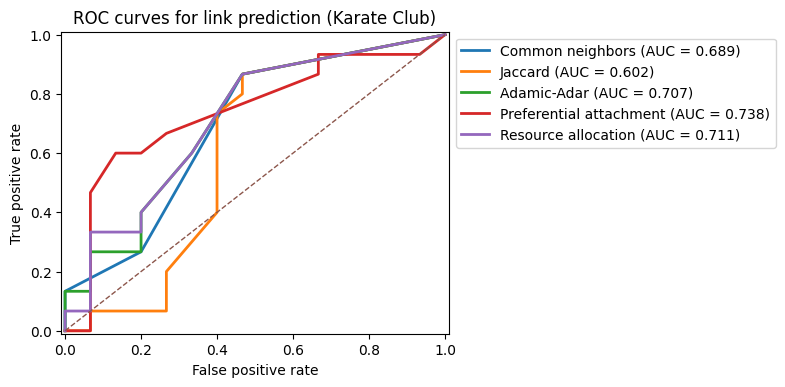

In [183]:
fig, ax = plt.subplots(1,1,figsize=(5, 4), dpi=100)

for name, scores in score_dict_karate.items():
    fpr, tpr, _ = roc_curve(y_karate, scores)
    auc = roc_auc_score(y_karate, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", lw=2)

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves for link prediction (Karate Club)")
ax.legend(bbox_to_anchor=[1.0,1.0],loc=2)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

### Your turn! Visualize the top 10 highest-score edges from each method in the plot below

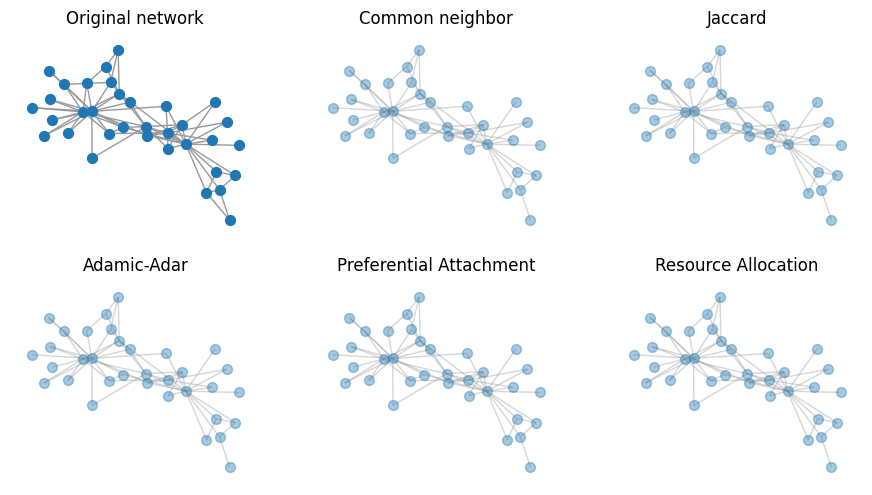

In [184]:
fig, ax = plt.subplots(2,3,figsize=(11,6),dpi=100)

# Original network
pos = nx.spring_layout(G_karate)
nx.draw(G_karate, pos, node_size=50, edge_color='.6', ax=ax[(0,0)])
ax[(0,0)].set_title('Original network')

#########################################

nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(0,1)], alpha=0.4)
G_tmp = nx.Graph()
G_tmp.add_nodes_from(G_karate.nodes())
# G_tmp.add_edges_from() ?????? add edges from 
# nx.draw(....., edge_color='orange', widths=2)
ax[(0,1)].set_title('Common neighbor')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(0,2)], alpha=0.4)
## ...
## ...
ax[(0,2)].set_title('Jaccard')



nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,0)], alpha=0.4)
## ...
## ...
ax[(1,0)].set_title('Adamic-Adar')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,1)], alpha=0.4)
## ...
## ...
ax[(1,1)].set_title('Preferential Attachment')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,2)], alpha=0.4)
## ...
## ...
ax[(1,2)].set_title('Resource Allocation')



plt.show()

_______

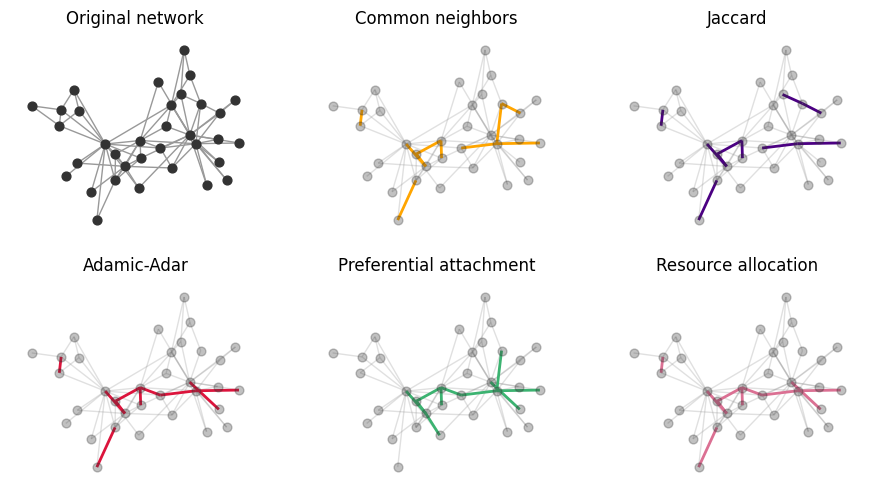

In [185]:
fig, ax = plt.subplots(2,3,figsize=(11,6),dpi=100)

# Original network
pos = nx.spring_layout(G_karate)
nx.draw(G_karate, pos, node_size=40, node_color='.2',
        edge_color='.6', ax=ax[(0,0)])
ax[(0,0)].set_title('Original network')

#############################

num_plot = 10
subplots = [(0,1),(0,2),(1,0),(1,1),(1,2)]
cols = ['orange',"indigo","crimson",'mediumseagreen','palevioletred']
zz = 0

for name, fn in [
    ("Common neighbors", common_neighbors_score),
    ("Jaccard", jaccard_score),
    ("Adamic-Adar", adamic_adar_score),
    ("Preferential attachment", preferential_attachment_score),
    ("Resource allocation", resource_allocation_score),
]:
    y, scores, auc = evaluate_score_function(
        G_karate_train, test_karate, neg_karate, fn, verbose=False
    )
    
    a = subplots[zz]

    G_tmp = nx.Graph()
    G_tmp.add_nodes_from(G_karate.nodes())

    zip_edges = dict(zip(test_karate, scores))
    zip_edges = dict(sorted(zip_edges.items(), key=lambda item: item[1], reverse=True))
    G_tmp.add_edges_from(list(zip_edges.keys())[:num_plot])
    
    nx.draw(G_karate_train, pos, node_size=40, node_color='.2',
            edge_color='.6', ax=ax[a], alpha=0.3)
    
    nx.draw_networkx_edges(G_tmp, pos, edge_color=cols[zz],
                           width=2, ax=ax[a])
    ax[a].set_title(name)
    zz += 1

plt.savefig('images/pngs/karate_lp.png',dpi=425,bbox_inches='tight')
plt.savefig('images/pdfs/karate_lp.pdf',bbox_inches='tight')
plt.show()

On this small friendship network, methods that emphasize shared neighborhoods (such as common neighbors, Adamic-Adar, and resource allocation) tend to perform comparatively well. This contrasts with the disassortative stochastic block model example below, where the same heuristics can come close to random performance.

-------

## When local heuristics fail: a disassortative SBM

Neighborhood-based scores implicitly assume a kind of **homophily**: nodes with similar neighbors tend to connect. This is often reasonable (social networks, collaboration networks) but not universal.

To see a failure case, consider a simple stochastic block model (SBM) with two groups of equal size where edges are more likely between groups than within groups. In this disassortative setting, many new edges connect structurally dissimilar nodes, and local similarity measures can perform poorly.

In [186]:
# Disassortative SBM
sizes = [40, 40]
p = [[0.02, 0.15],
     [0.15, 0.02]]

G_sbm = nx.stochastic_block_model(sizes, p, seed=SEED)

G_sbm_train, test_sbm, neg_sbm = train_test_split_graph(
    G_sbm, test_frac=0.2, seed=SEED, ensure_connected=True
)

print("SBM (disassortative)")
print("  Nodes:", G_sbm.number_of_nodes())
print("  Edges:", G_sbm.number_of_edges())
print("  Test positives:", len(test_sbm))
print("  Test negatives:", len(neg_sbm))


SBM (disassortative)
  Nodes: 80
  Edges: 284
  Test positives: 56
  Test negatives: 56


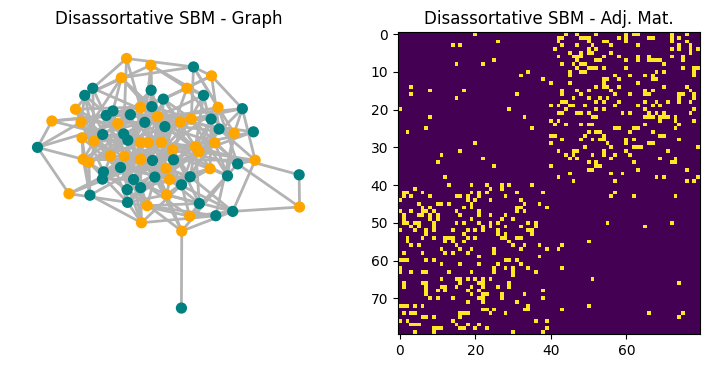

In [187]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=100)

nx.draw(G_sbm,node_size=50,width=2,edge_color='.7',
        node_color=['orange']*40+['teal']*40,ax=ax[0])
ax[1].imshow(nx.to_numpy_array(G_sbm))

ax[0].set_title('Disassortative SBM - Graph')
ax[1].set_title('Disassortative SBM - Adj. Mat.')

plt.show()

In [188]:
results = {}
for name, fn in [
    ("Common Neighb", common_neighbors_score),
    ("Jaccard Score", jaccard_score),
    ("Adamic-Adar", adamic_adar_score),
    ("Pref. Attach", preferential_attachment_score),
    ("Resour. Alloc", resource_allocation_score),
]:
    y, s, auc = evaluate_score_function(G_sbm_train, test_sbm, neg_sbm, fn, verbose=False)
    results[name] = (y, s, auc)


for name, (y, s, auc) in results.items():
    print(f"{name}:\t SBM ROC-AUC = {auc:.3f}")

Common Neighb:	 SBM ROC-AUC = 0.371
Jaccard Score:	 SBM ROC-AUC = 0.370
Adamic-Adar:	 SBM ROC-AUC = 0.363
Pref. Attach:	 SBM ROC-AUC = 0.538
Resour. Alloc:	 SBM ROC-AUC = 0.363


On this disassortative network, performance can be much closer to (or worse than!) random. This example underscores that link prediction methods are not universally reliable; they encode assumptions about how edges form.

### Homophily vs. heterophily (bipartite networks, similarity/complementary)

- Homophily suggests that similar nodes are more likely to connect, whereas heterophily implies connections between dissimilar nodes.
- Homophily-based methods (like common neighbors or Jaccard) work well for networks where similar nodes are connected, but they struggle in heterophilic networks.
- For networks formed through heterophily (e.g., connections between dissimilar or complementary nodes), we might need different predictors or additional features (such as node attributes) to account for these dissimilarities.

There are some papers taking in consideration of such features, including: [Zheng at al, 2022](https://arxiv.org/abs/2202.07082), [Zhu et al., 2021](https://arxiv.org/abs/2009.13566), and [Kovacs et al, 2019](https://www.nature.com/articles/s41467-019-09177-y)

![](images/proteins.png)

### Final point: Link prediction and recommendation systems

It is useful to make explicit how link prediction relates to what is usually called "recommendation." Many recommender systems can be represented as a **bipartite graph** between a set of users $i$ and a set of items $I$. An edge $(u, i)$ indicates that user $u \in U$ has interacted with item $i \in I$ (watched a movie, purchased a product, clicked a link, followed an account, and so on). The goal of recommendation is then:

> For each user $u$, identify a small set of items $i$ such that the missing edges $(u, i)$ are most likely to appear in the future.

This is exactly a link prediction problem on a bipartite graph. The candidate set consists of all non-edges $(u, i)$ that are not currently observed; a recommendation algorithm assigns a score $s(u, i)$ to each candidate pair and returns the top-$k$ items per user. The evaluation metrics are essentially the same as in this chapter:

* ROC-AUC and related ranking metrics (such as average precision) measure how well the algorithm separates edges that will appear from those that will not.
* Precision@$k$ measures the fraction of recommended items that correspond to true future interactions.

The main differences are pragmatic rather than conceptual. Real recommendation systems must often cope with:

* extremely large candidate sets and severe class imbalance,
* side information about users and items (attributes, content, context),
* strong temporal and causal constraints (for example, avoiding using future interactions when training).

But at their core, many recommender algorithms—especially graph-based ones—are specialized link prediction methods applied to user-item interaction networks.

______________

In this chapter, we treated link prediction as the problem of ranking node pairs according to how likely they are to form an edge, rather than as a simple yes/no classification task.

The story of link prediction has progressed far beyond the hand-crafted structural scores and simple baselines we covered today. Now, there are tons of modern machine-learning approaches to link prediction and graph representation learning. These include random-walk-based embeddings such as DeepWalk and node2vec, which learn vector representations of nodes by treating truncated walks as "sentences" (Perozzi et al., 2014; Grover and Leskovec, 2016), as well as graph neural network architectures like GCNs and GATs that learn to aggregate information from neighbors through trainable message-passing layers (Kipf and Welling, 2017; Veličković et al., 2018; Hamilton et al., 2017). There is also a growing literature on stacking and ensembling models for nearly optimal link prediction (Ghasemian et al., 2020) and on designing architectures that perform well on heterogeneous or heterophilous graphs (Dong et al., 2017; Wang et al., 2019; Fu et al., 2020; Zheng et al., 2022; Zhu et al., 2021). If you are interested in going beyond the classical heuristics and simple supervised baselines presented here, the references above provide a roadmap into this rapidly evolving area.


__________
## Next time...
Bayesian Methods & Expectation Maximization `class_03_bayesian_inference_em.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/network-science-data-and-models/cnet5052_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5052-spring26
2. Adamic, L. A., & Adar, E. (2003). Friends and neighbors on the web. *Social Networks*, 25(3), 211–230. https://doi.org/10.1016/S0378-8733(03)00009-1
3. Albert, R., & Barabási, A.-L. (2002). Statistical mechanics of complex networks. *Reviews of Modern Physics*, 74(1), 47–97. https://doi.org/10.1103/RevModPhys.74.47
4. Clauset, A., Moore, C., & Newman, M. E. J. (2008). Hierarchical structure and the prediction of missing links in networks. *Nature*, 453(7191), 98–101. https://doi.org/10.1038/nature06830
5. Fawcett, T. (2006). An introduction to ROC analysis. *Pattern Recognition Letters*, 27(8), 861–874. https://doi.org/10.1016/j.patrec.2005.10.010
6. Katz, L. (1953). A new status index derived from sociometric analysis. *Psychometrika*, 18(1), 39–43. https://doi.org/10.1007/BF02289026
7. Liben-Nowell, D., & Kleinberg, J. (2007). The link-prediction problem for social networks. *Journal of the American Society for Information Science and Technology*, 58(7), 1019–1031. https://doi.org/10.1002/asi.20591
8. Lü, L., & Zhou, T. (2011). Link prediction in complex networks: A survey. *Physica A: Statistical Mechanics and its Applications*, 390(6), 1150–1170. https://doi.org/10.1016/j.physa.2010.11.027
9. Newman, M. E. J. (2018). *Networks* (2nd ed.). Oxford University Press.
10. Ghasemian, A., Hosseinmardi, H., Galstyan, A., Airoldi, E. M., & Clauset, A. (2020). Stacking models for nearly optimal link prediction in complex networks. *Proceedings of the National Academy of Sciences of the United States of America*, 117(38), 23393–23400. https://doi.org/10.1073/pnas.1914950117
11. Newman, M. E. J., & Reinert, G. (2016). Estimating the number of communities in a network. *Physical Review Letters*, 117(7), 078301. https://doi.org/10.1103/PhysRevLett.117.078301
12. Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure in networks. *Physical Review E*, 69(2), 026113. https://doi.org/10.1103/PhysRevE.69.026113
13. Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online learning of social representations. In *Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’14)* (pp. 701–710). https://doi.org/10.1145/2623330.2623732
14. Grover, A., & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’16)* (pp. 855–864). https://doi.org/10.1145/2939672.2939754
15. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). Graph attention networks. In *International Conference on Learning Representations (ICLR 2018)*. arXiv:1710.10903. https://arxiv.org/abs/1710.10903
16. Kipf, T. N., & Welling, M. (2017). Semi-supervised classification with graph convolutional networks. In *International Conference on Learning Representations (ICLR 2017)*. arXiv:1609.02907. https://arxiv.org/abs/1609.02907
17. Hamilton, W. L., Ying, R., & Leskovec, J. (2017). Inductive representation learning on large graphs. In *Advances in Neural Information Processing Systems (NeurIPS 2017)* (pp. 1025–1035). arXiv:1706.02216. https://arxiv.org/abs/1706.02216
18. Dong, Y., Chawla, N. V., & Swami, A. (2017). metapath2vec: Scalable representation learning for heterogeneous networks. In *Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’17)* (pp. 135–144). https://doi.org/10.1145/3097983.3098036
19. Wang, X., Ji, H., Shi, C., Wang, B., Ye, Y., Cui, P., & Yu, P. S. (2019). Heterogeneous graph attention network. In *Proceedings of the World Wide Web Conference (WWW 2019)* (pp. 2022–2032). https://doi.org/10.1145/3308558.3313562
20. Fu, X., Zhang, J., Meng, Z., & King, I. (2020). MAGNN: Metapath aggregated graph neural network for heterogeneous graph embedding. In *Proceedings of the Web Conference 2020 (WWW ’20)* (pp. 2331–2341). https://doi.org/10.1145/3366423.3380297
21. Zheng, X., Wang, Y., Liu, Y., Li, M., Zhang, M., Jin, D., Yu, P. S., & Pan, S. (2022). Graph neural networks for graphs with heterophily: A survey. *arXiv preprint* arXiv:2202.07082. https://arxiv.org/abs/2202.07082
22. Zhu, J., Rossi, R. A., Rao, A., Mai, T., Lipka, N., Ahmed, N. K., & Koutra, D. (2021). Graph neural networks with heterophily. *Proceedings of the AAAI Conference on Artificial Intelligence*, 35(12), 11168–11176. https://doi.org/10.1609/aaai.v35i12.17332